In [2]:
import soundfile as sf
import librosa
from IPython.display import Audio
import scipy.io.wavfile as sc
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [3]:
i = 'class1.cls'
with open('class_200/'+i) as f:
    lines = f.readlines()
lines = lines[1:]

In [4]:
count = 0
for line in lines:
    if count == 1:
        break
    region = line[:3].upper()
    speaker = line[3: 8].upper()
    j = 11
    while line[j] != 'w':
        j += 1
    sent = line[8: j].upper()
    ext = line[j:j+3].upper()
    start = line[j+4: j+9]
    end = line[j+10:j+15]
    audio = 'TIMIT/TRAIN/'+region+'/'+speaker+'/'+sent+'.'+ext
    print(audio)
    '''audio_section, sample_rate = read_audio_section(audio, int(start), int(end))
    [F1, data1] = sc.read(audio)
    plt.plot(data1)'''
    x, sr = librosa.load(audio, sr = 16000)
    Audio(data=audio, autoplay = False)
    count += 1

TIMIT/TRAIN/DR1/FDAW0/SA1.WAV


## format of 1.cls file
dr1fdaw0sa1wav,1.505,1.525

In [5]:
Audio(data=audio, autoplay = False)

In [6]:
Duration = len(x)/sr
print(Duration, 'secs')

3.34725 secs


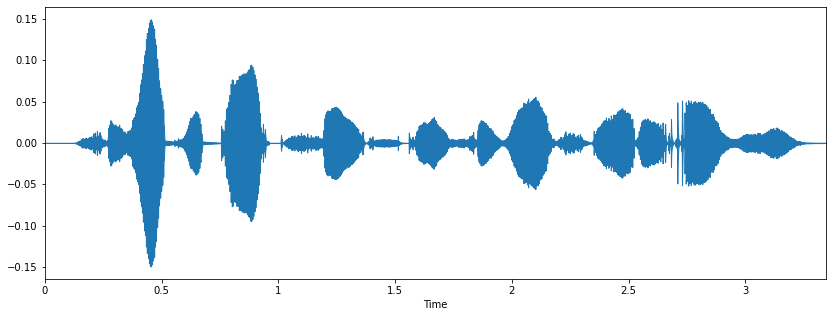

In [7]:
plt.figure(figsize=(14, 5))
#plotting the sampled signal
librosa.display.waveplot(x, sr=sr)

## Pre-emphasis
Pre-emphasis is done before starting with feature extraction. We do this by boosting only the signal’s high-frequency components, while leaving the low-frequency components in their original states. This is done in order to compensate the high-frequency section, which is suppressed naturally when humans make sounds.

Text(0.5, 1.0, 'Original signal')

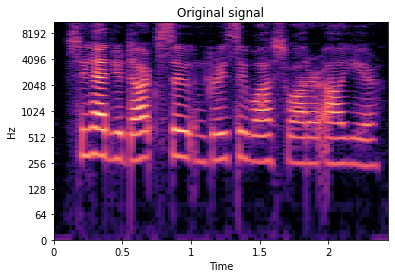

In [8]:
y, sr = librosa.load(audio, sr)
x = librosa.effects.preemphasis(y)
# and plot the results for comparison
S_orig = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
S_preemph = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)

librosa.display.specshow(S_orig, y_axis='log', x_axis='time')
plt.title('Original signal')

Text(0.5, 1.0, 'Pre-emphasized signal')

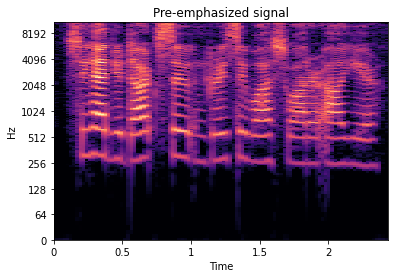

In [9]:
librosa.display.specshow(S_preemph, y_axis='log', x_axis='time')
plt.title('Pre-emphasized signal')

In [10]:
start = float(start)
end = float(end)
print('start boundary: ', start, '\nend boundary: ', end)

start boundary:  1.505 
end boundary:  1.525


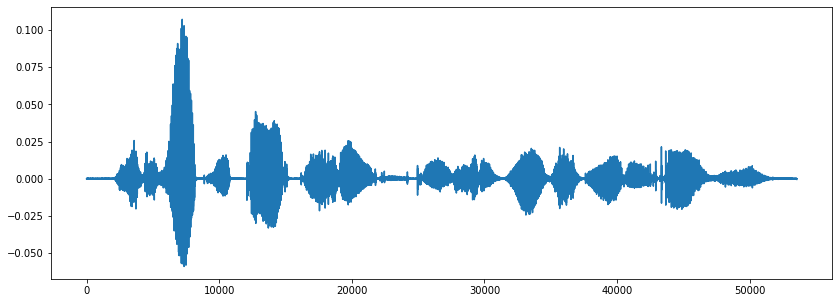

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(x)

## Log energy

In [12]:
samples = int(sr*Duration)

In [13]:
# we have 320 samples in 20ms from the sr=16000
time_boundary_duration = round(end-start, 3) # 20ms
frame_size = int((samples*time_boundary_duration*1000)/(Duration*1000))
hop_length = int(frame_size/2)

In [14]:
print('frame size: ', frame_size, '\nhop length: ', hop_length)

frame size:  320 
hop length:  160


In [15]:
le_start = round(start-0.1, 3)
le_end = round(end+0.1, 3)
le_n0 = int(le_start*16000)
le_n1 = int(le_end*16000)

In [16]:
le_n0 = 40370-1600
le_n1 = 40690+1600

In [17]:
normalize = max(x[le_n0:le_n1])/2

In [18]:
rms_audio = librosa.feature.rms(x[le_n0:le_n1], frame_length=frame_size, hop_length=hop_length)[0]

In [19]:
rms_audio

array([0.0039994 , 0.00425041, 0.0046357 , 0.00483225, 0.00459502,
       0.00464033, 0.00472494, 0.00436869, 0.00392521, 0.00310495,
       0.00192519, 0.00081717, 0.00131941, 0.00218914, 0.00274996,
       0.00290928, 0.00275291, 0.00240792, 0.0024852 , 0.00260447,
       0.00231727, 0.00206173, 0.00199189], dtype=float32)

In [20]:
frames = range(len(rms_audio))
t = librosa.frames_to_time(frames, hop_length=hop_length)

Text(0.5, 1.0, 'Log Energy')

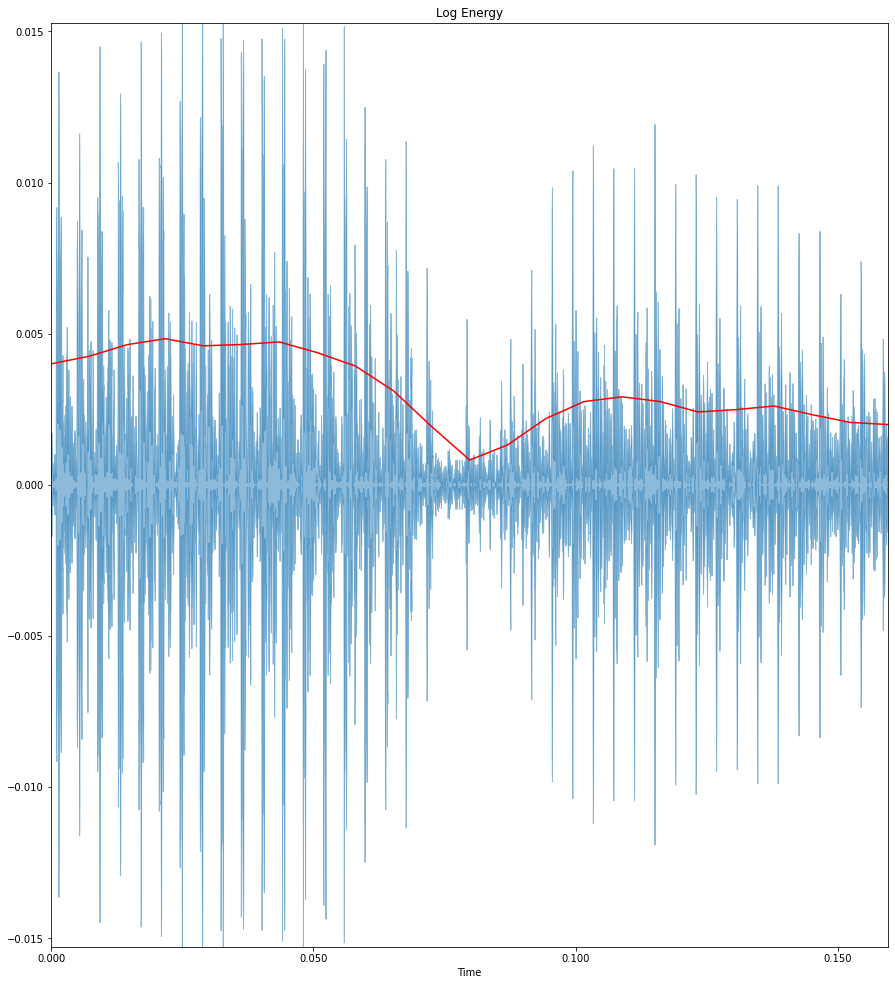

In [21]:
plt.figure(figsize=(15, 17))
librosa.display.waveplot(x[le_n0:le_n1], alpha=0.5)
plt.plot(t, rms_audio, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Log Energy")
#plt.savefig('water_le')

In [22]:
boudary duration = 20ms
time boundary = 220ms
block = 100ms

SyntaxError: invalid syntax (<ipython-input-22-268b14046468>, line 1)

In [23]:
# to be considered as a word boundary it should be closer to max zero crossing as well as
# min zero crossing
indx = len(rms_audio)//2-1
print(rms_audio[indx])
count = 0
flag = 0
while count < 3:
    if rms_audio[indx-count] == min(rms_audio):
        flag += 1
        break
    if rms_audio[indx+count] == min(rms_audio):
        flag += 1
        break
    count += 1
if flag == 1:
    print('Word boundary')
else: print('Not a word boundary')

0.0019251938
Word boundary


## zero crossing rate

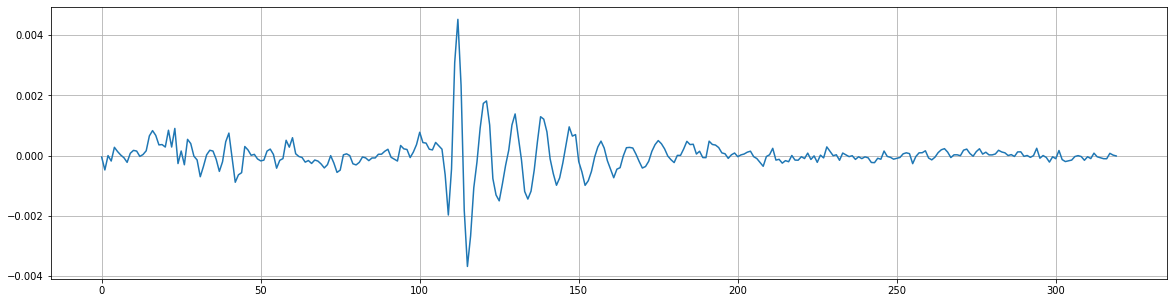

In [24]:
#zero crossings to be found between a given time
n0 = int(start*sr)
n1 = int(end*sr)
plt.figure(figsize=(20, 5))
plt.plot(x[n0:n1])
plt.grid()

In [25]:
end

1.525

In [26]:
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

96


In [27]:
x_start = round(start-0.1, 3)
x_end = round(end+0.1, 3)

In [28]:
x_start = round((40370/16000) - 0.1, 3)
x_end = round((40690/16000)+0.1, 3)

In [29]:
#100ms before and after the time boundary
zc_100 = []
zc_100.append(sum(librosa.zero_crossings(x[int(le_n0-hop_length):int(le_n0+hop_length)], pad=False)))
while x_start <= x_end:
    x_n0 = int(x_start*sr)
    x_n1 = int((x_start+time_boundary_duration)*sr)
    x_zero_crossings = librosa.zero_crossings(x[x_n0:x_n1], pad=False)
    zc_100.append(sum(x_zero_crossings))
    x_start += time_boundary_duration/2
    #x_start = round(x_start, 3)
print(zc_100)

[50, 53, 60, 54, 50, 52, 57, 65, 70, 63, 78, 106, 91, 70, 66, 62, 57, 62, 66, 61, 50, 50, 60, 68]


In [30]:
frames = range(len(zc_100))
t = librosa.frames_to_time(frames, hop_length=int(time_boundary_duration*16000)/2)

In [31]:
mxzc = max(zc_100)
divisor = mxzc/normalize
for i in range(len(zc_100)):
    zc_100[i] = zc_100[i]/divisor

Text(0.5, 1.0, 'Zero Crossing')

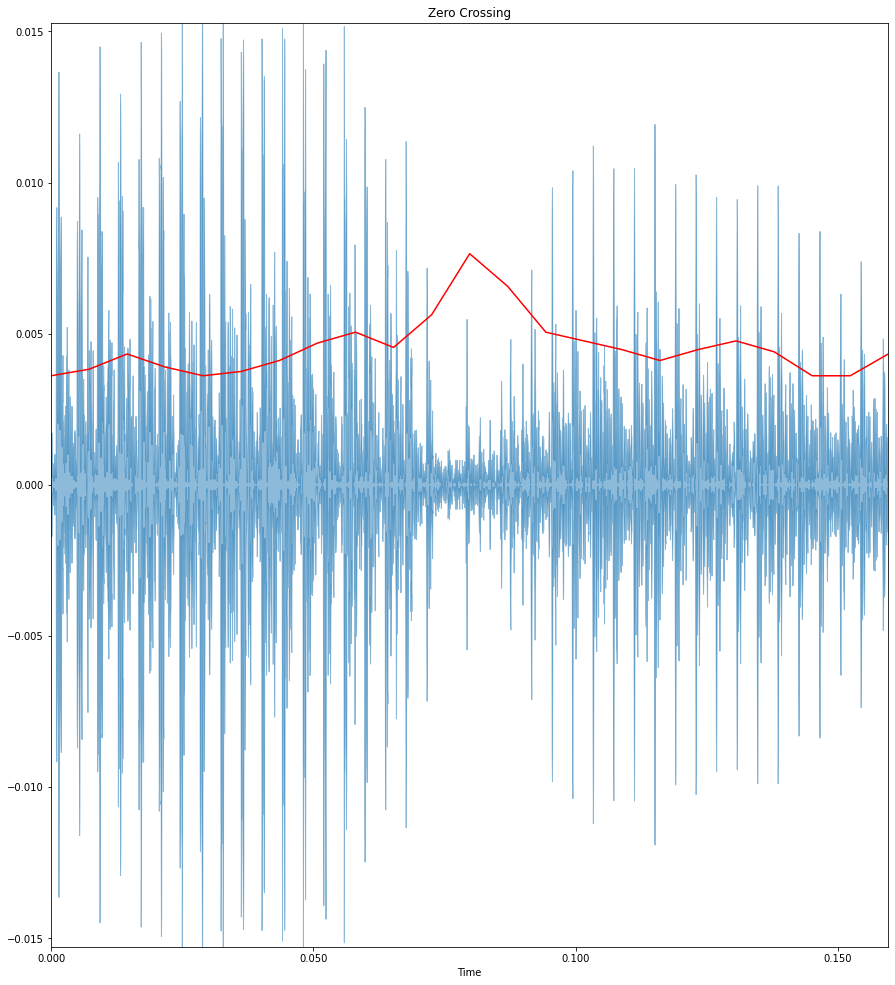

In [32]:
plt.figure(figsize=(15, 17))
librosa.display.waveplot(x[le_n0:le_n1], alpha=0.5)
plt.plot(t, zc_100, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Zero Crossing")
#plt.savefig('water_zc')

In [33]:
# to be considered as a word boundary it should be closer to max zero crossing as well as
# min zero crossing
indx = len(zc_100)//2-1
print(zc_100[indx])
count = 0
flag = 0
while count < 3:
    if zc_100[indx-count] == max(zc_100):
        flag += 1
        break
    if zc_100[indx+count] == max(zc_100):
        flag += 1
        break
    count += 1
if flag == 1:
    print('Word boundary')
else: print('Not a word boundary')

0.0076440428383648396
Word boundary


## Pitch(short time pitch frequency)

In [34]:
%pylab inline
rcParams["figure.figsize"] = (14, 5)

Populating the interactive namespace from numpy and matplotlib


/home/sauravkoranga/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['flag', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [35]:
import pyreaper
from scipy.io import wavfile
from IPython.display import Audio

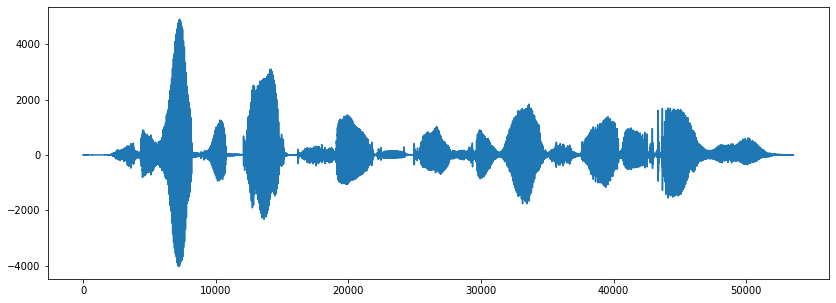

In [36]:
fs, y = wavfile.read(audio)
plot(y)
Audio(y, rate=fs)

In [43]:
pm_times, pm, f0_times, f0, corr = pyreaper.reaper(y, fs)

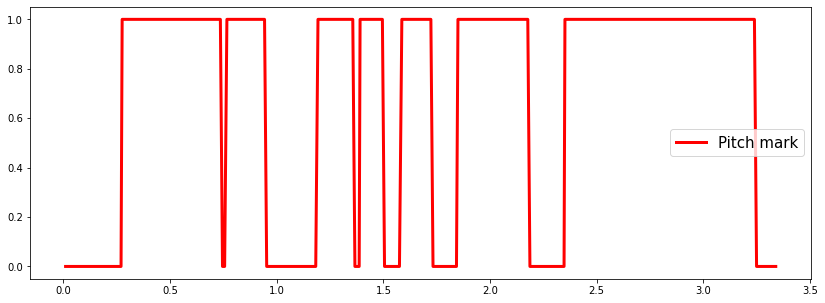

In [44]:
plt.figure(figsize=(14,5))
plt.plot(pm_times, pm, linewidth=3, color="red", label="Pitch mark")
legend(fontsize=15)
# Saving the figure.
plt.savefig("pitch.jpg")

Text(0.5, 1.0, 'Pitch')

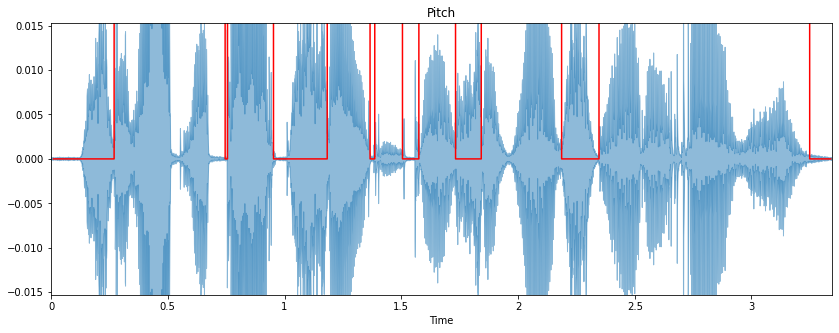

In [45]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.5)
plt.plot(pm_times, pm, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Pitch")
#plt.savefig("pitch_signal.jpg")

In [46]:
pm_times, pm, f0_times, f0, corr = pyreaper.reaper(y[le_n0:le_n1], fs)

In [47]:
normalize

0.0076440428383648396

In [48]:
pm_ = [0]*len(pm)
for i in range(len(pm)):
    if pm[i] == 1:
        pm_[i] = normalize
    else: pm_[i] = 0

Text(0.5, 1.0, 'Pitch')

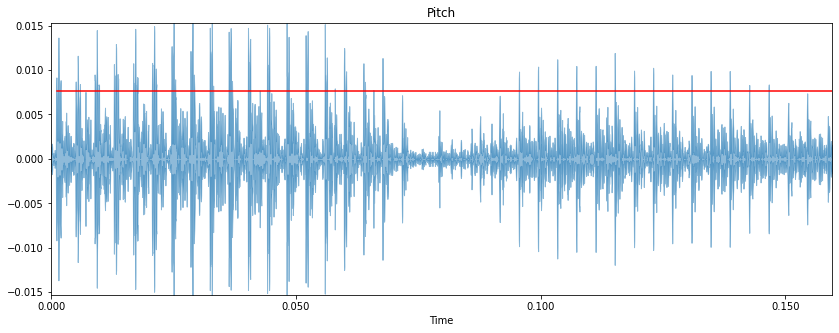

In [50]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[le_n0:le_n1], alpha=0.5)
plt.plot(pm_times, pm_, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Pitch")
#plt.savefig("pitch_audio.jpg")

In [51]:
# to be considered as a word boundary it should be closer to max zero crossing as well as
# min zero crossing
indx = len(pm_)//2-1
print(pm_[indx])
count = 0
flag = 0
while count < 3:
    if pm_[indx-count] == 0:
        flag += 1
        break
    if pm_[indx+count] == 0:
        flag += 1
        break
    count += 1
if flag == 1:
    print('Word boundary')
else: print('Not a word boundary')

0.0076440428383648396
Not a word boundary


# Higher Order features

## Kurtosis and Skewness
A positive kurtosis indicates a "heavy-tailed" distribution and negative kurtosis indicates a "light tailed" distribution.

Negative values for the skewness indicate data that are skewed left and positive values for the skewness indicate data that are skewed right. By skewed left, we mean that the left tail is long relative to the right tail.

In [52]:
from scipy.stats import kurtosis, skew

In [53]:
time_boundary_duration

0.02

In [54]:
x_start = le_start
x_end = le_end

In [55]:
#x_start = round((40370/16000) - 0.1, 3)
#x_end = round((40690/16000)+0.1, 3)
x_start = 0
x_end = Duration

In [56]:
#100ms before and after the time boundary
k = []
k.append((kurtosis(x[int(le_n0-hop_length):int(le_n0+hop_length)])))
while x_start <= x_end:
    x_n0 = int(x_start*sr)
    x_n1 = int((x_start+time_boundary_duration)*sr)
    kurt = kurtosis(x[x_n0:x_n1])
    k.append(kurt)
    x_start += time_boundary_duration/2
    #x_start = round(x_start, 3)

In [57]:
len(k)

336

In [58]:
mxzc = max(k)
divisor = mxzc/normalize
for i in range(len(k)):
    k[i] = k[i]/divisor

In [59]:
frames = range(len(k))
t = librosa.frames_to_time(frames, hop_length=hop_length)

In [60]:
frames

range(0, 336)

In [61]:
normalize=0.1

Text(0.5, 1.0, 'Kurtosis')

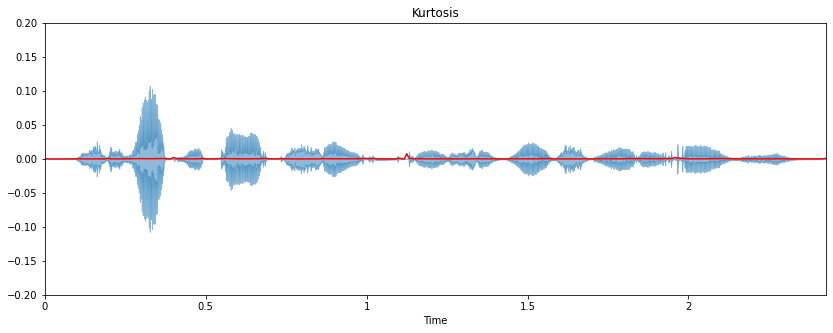

In [62]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, alpha=0.5)
plt.plot(t, k, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Kurtosis")
#plt.savefig('water_kurt')

In [63]:
#skewness

In [64]:
x_start = le_start
x_end = le_end

In [65]:
x_start = 0
x_end = Duration

In [66]:
#100ms before and after the time boundary
s = []
s.append((skew(x[int(le_n0-hop_length):int(le_n0+hop_length)])))
while x_start < x_end:
    x_n0 = int(x_start*sr)
    x_n1 = int((x_start+time_boundary_duration)*sr)
    sk = skew(x[x_n0:x_n1])
    s.append(sk)
    x_start += time_boundary_duration/2

In [67]:
mxzc = max(s)
divisor = mxzc/normalize
for i in range(len(s)):
    s[i] = s[i]/divisor

In [68]:
frames = range(len(s))
t = librosa.frames_to_time(frames, hop_length=hop_length)

Text(0.5, 1.0, 'Skewness')

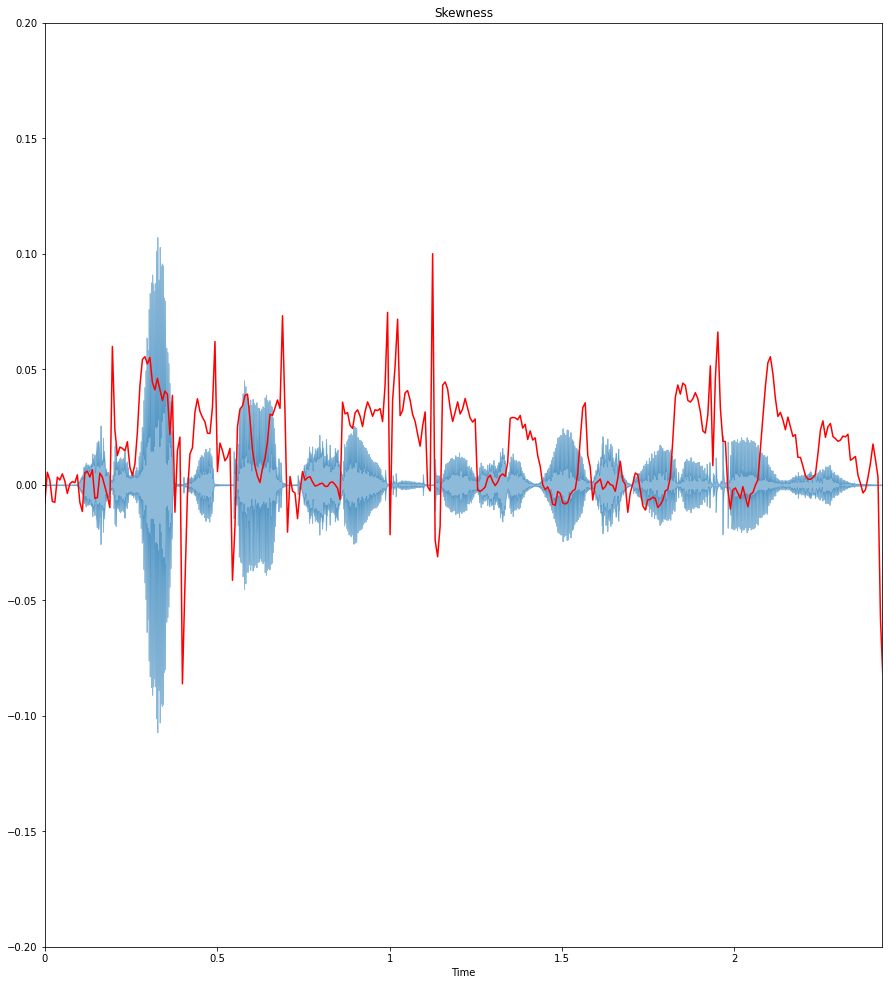

In [69]:
plt.figure(figsize=(15, 17))
librosa.display.waveplot(x, alpha=0.5)
plt.plot(t, s, color="r")
plt.ylim((-normalize*2, normalize*2))
plt.title("Skewness")
#plt.savefig('water_skew')

## Bispectral Features
The  bispectrum  is  the  frequency  domain  representation  of  the  third-order  cumu-lant or moment. Bicoherence is the normalized representation of the bispectrum.Processes that deviate from Gaussianity and linearity can conveniently be studiedby using higher order statistics, particularly the bispectrum and bicoherence

In [70]:
duration = len(x)/sr
time = np.arange(0,duration,1/sr) #time vector

In [71]:
xf = np.array([x, time], np.float32)

In [72]:
from polycoherence import _plot_signal, polycoherence, plot_polycoherence

In [73]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len

In [74]:
frame_size = 320

In [75]:
N= samples
kw = dict(nperseg=frame_size, noverlap=frame_size // 2, nfft=frame_size*2)
kw

{'nperseg': 320, 'noverlap': 160, 'nfft': 640}

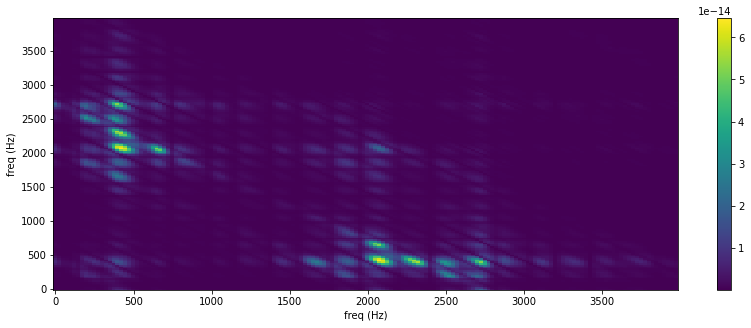

In [76]:
freq1, freq2, bispec = polycoherence(x[10630:11110], sr, norm=None, **kw)
plot_polycoherence(freq1, freq2, bispec)

In [77]:
# bicoh capturing for fs 480

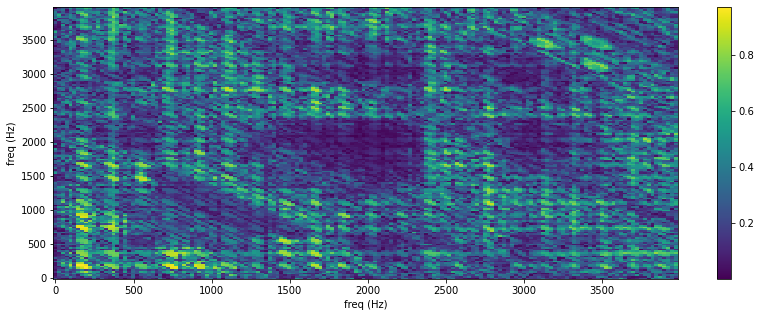

In [78]:
freq1, freq2, bicoh = polycoherence(y[40370-1600 :40690+1600], sr, **kw)
plot_polycoherence(freq1, freq2, bicoh)

In [79]:
bicoh

array([[2.4043334e-01+0.j, 8.0517456e-02+0.j, 3.1992171e-02+0.j, ...,
        3.9604938e-01+0.j, 2.5393996e-01+0.j, 2.4697420e-04+0.j],
       [8.0517456e-02+0.j, 1.5922816e-01+0.j, 2.2438511e-01+0.j, ...,
        1.1727514e-01+0.j, 2.6245773e-01+0.j, 1.8008597e-01+0.j],
       [3.1992171e-02+0.j, 2.2438511e-01+0.j, 1.8017323e-01+0.j, ...,
        2.8064439e-01+0.j, 3.6711675e-01+0.j, 2.9995018e-01+0.j],
       ...,
       [3.9604938e-01+0.j, 1.1727514e-01+0.j, 2.8064439e-01+0.j, ...,
        2.9866710e-01+0.j, 4.5381039e-01+0.j, 4.7469851e-01+0.j],
       [2.5393996e-01+0.j, 2.6245773e-01+0.j, 3.6711675e-01+0.j, ...,
        4.5381039e-01+0.j, 3.0108938e-01+0.j, 1.6846217e-01+0.j],
       [2.4697420e-04+0.j, 1.8008597e-01+0.j, 2.9995018e-01+0.j, ...,
        4.7469851e-01+0.j, 1.6846217e-01+0.j, 2.4063547e-01+0.j]],
      dtype=complex64)

In [80]:
def normalize_freq(freq, sr):
    for i in range(len(freq)):
        freq[i] /= sr
    return freq

In [81]:
freq1 = normalize_freq(freq1, sr)
freq2 = normalize_freq(freq2, sr)

In [82]:
column_sums = bicoh.sum(axis=0)

In [83]:
bicoh_norm = [float(i)/len(column_sums) for i in column_sums]

<ipython-input-83-22001ed16e2e>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]


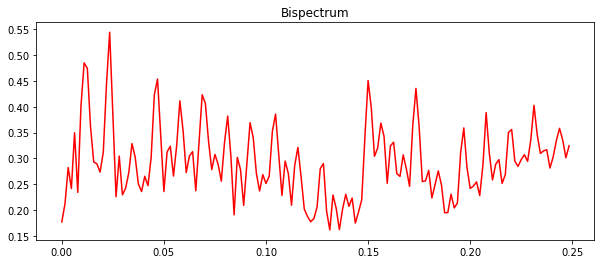

In [84]:
plt.figure(figsize=(10, 4))
#librosa.display.waveplot(x[le_n0:le_n1], alpha=0.5)
plt.plot(freq1, bicoh_norm, color="r")
#plt.ylim((-normalize*2, normalize*2))
plt.title("Bispectrum")
# Saving the figure.
plt.savefig("voiced.jpg")

(-0.01, 0.01)

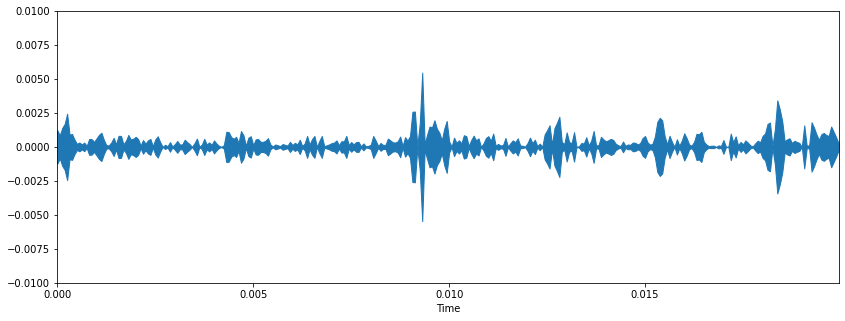

In [85]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x[40370 :40690], sr=sr)
plt.ylim((-0.01, 0.01))

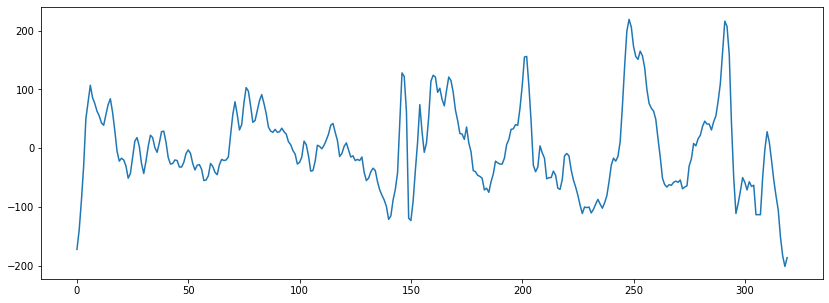

In [86]:
plot(y[40370 :40690])

## complete audio

<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_

<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_

<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_

<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_

<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
<ipython-input-952-89ae314de523>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  bicoh_

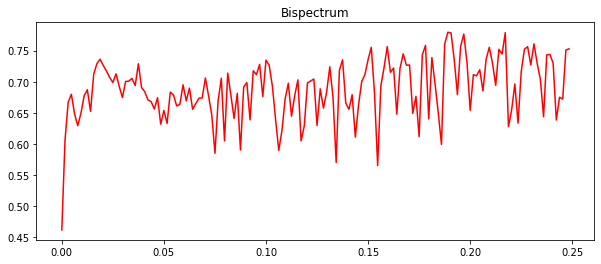

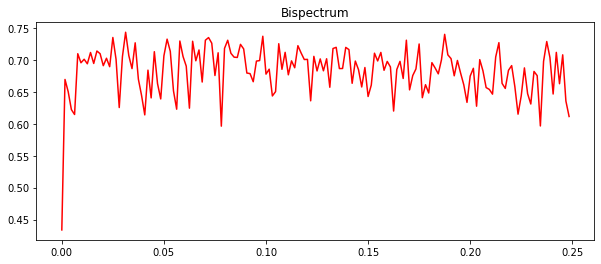

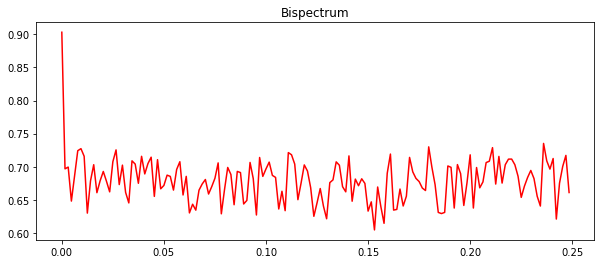

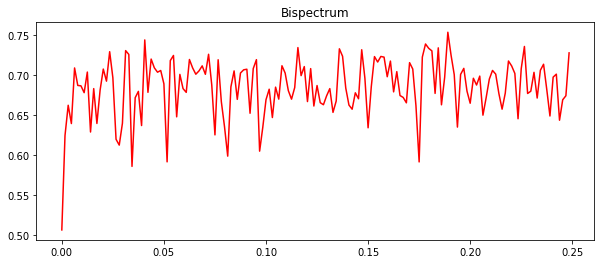

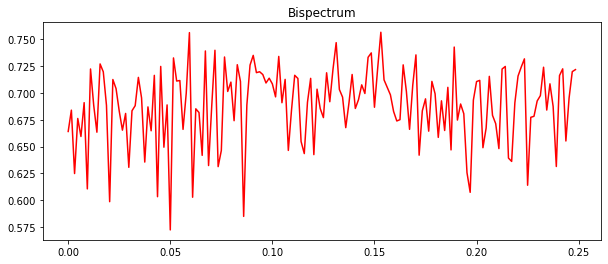

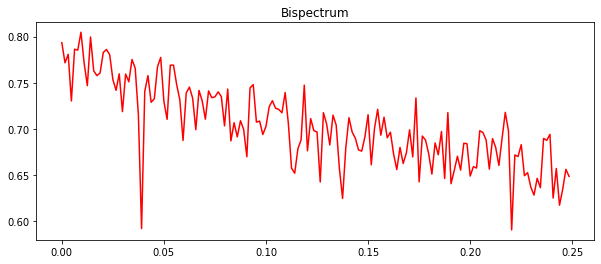

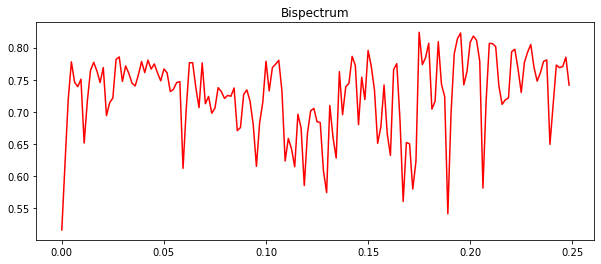

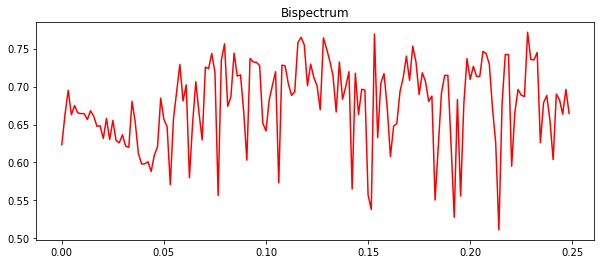

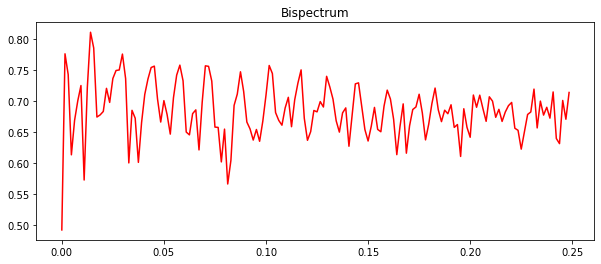

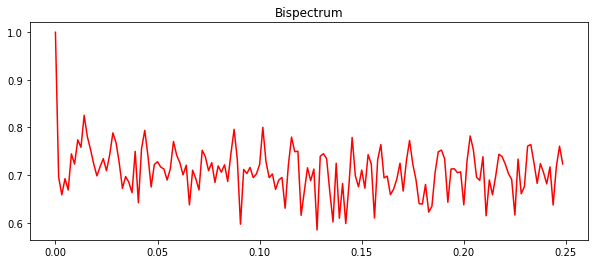

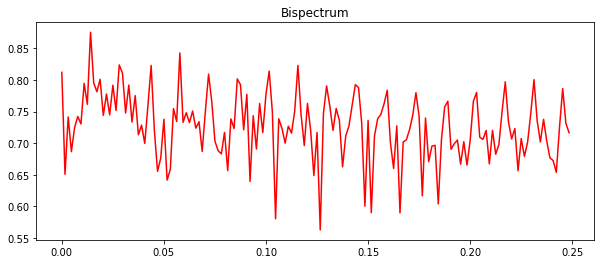

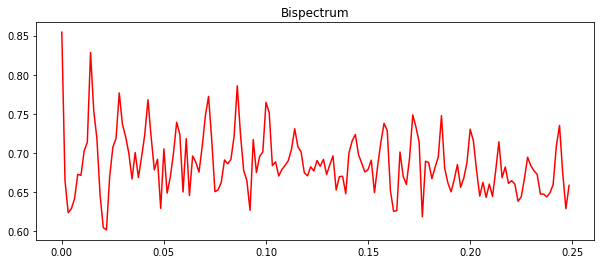

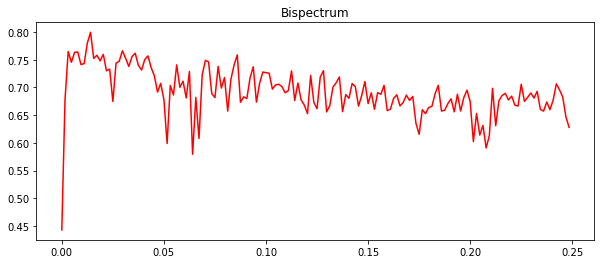

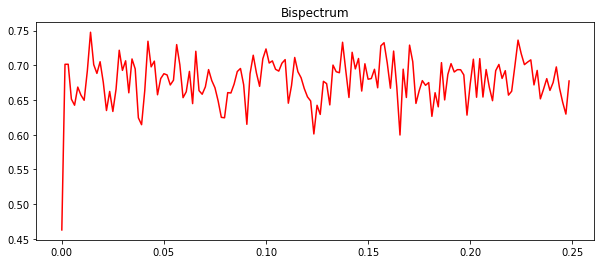

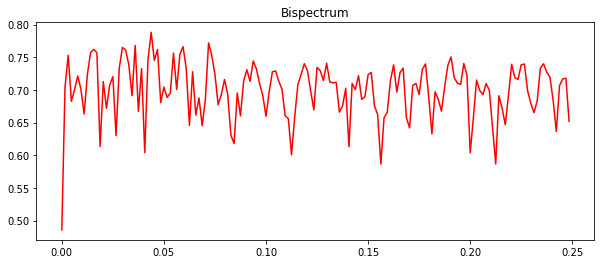

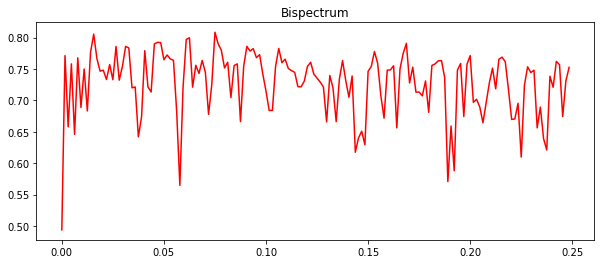

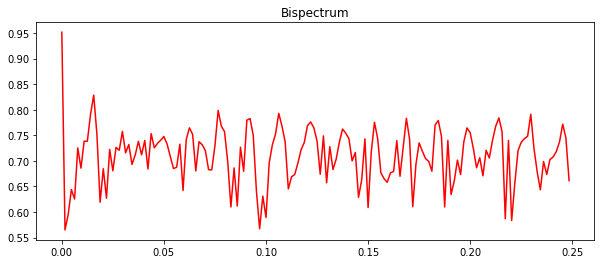

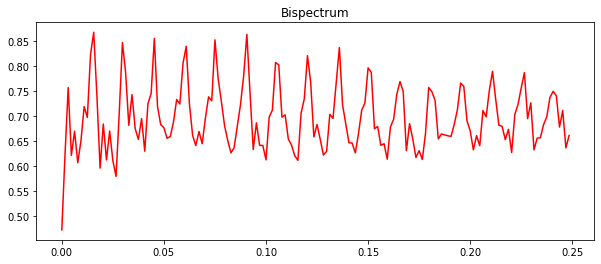

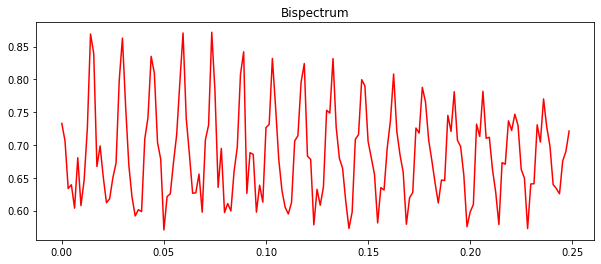

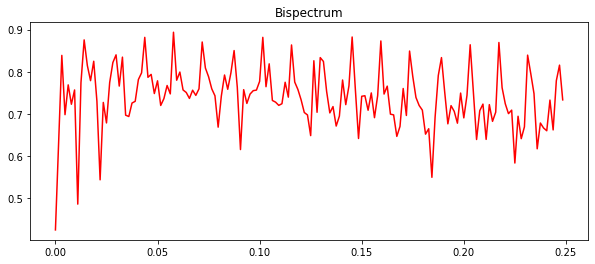

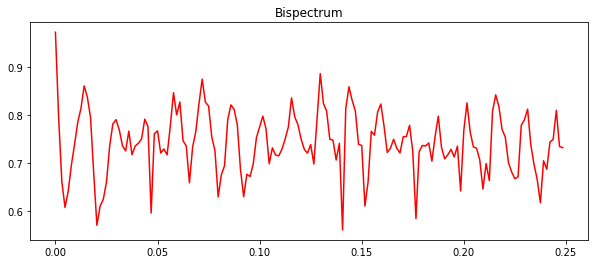

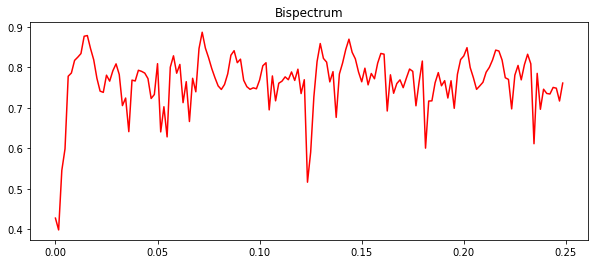

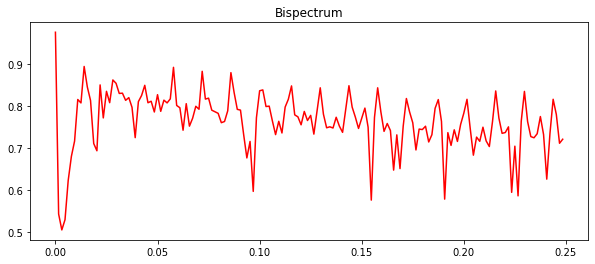

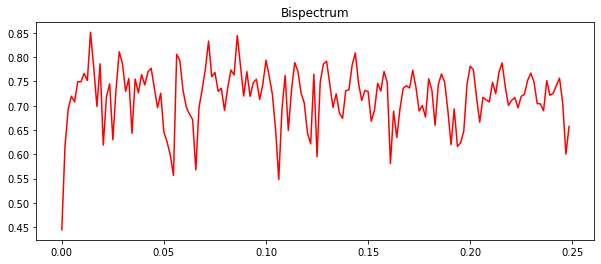

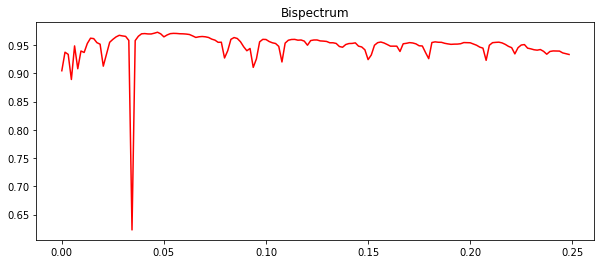

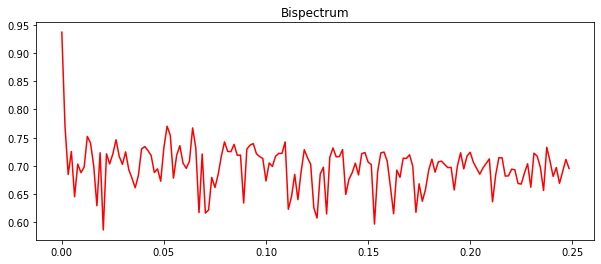

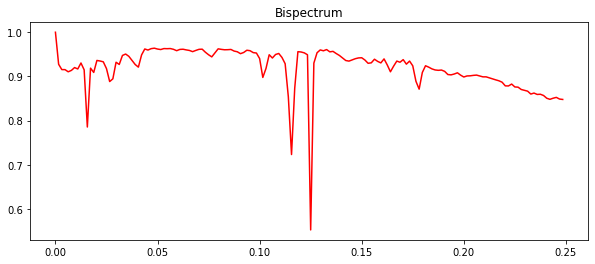

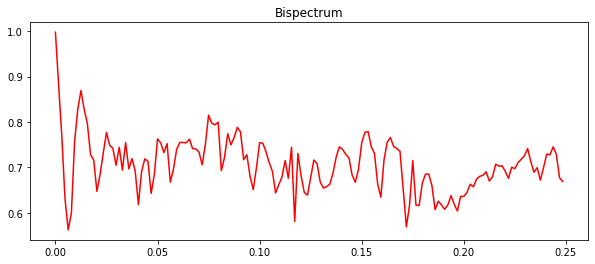

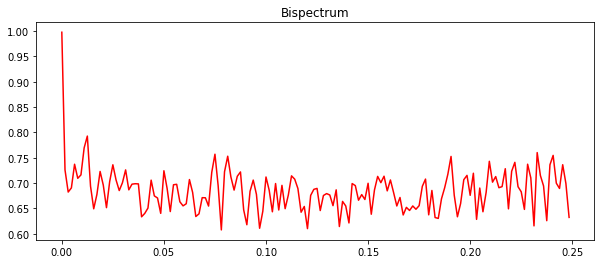

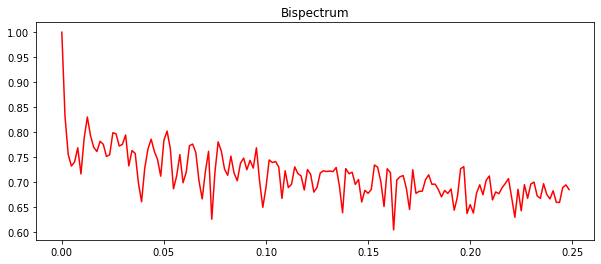

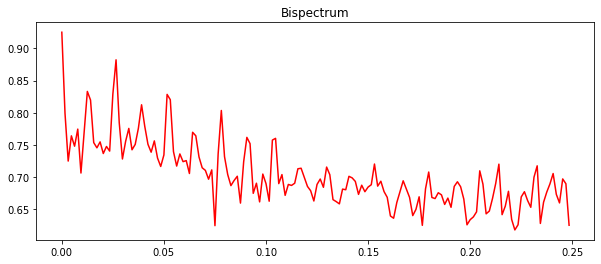

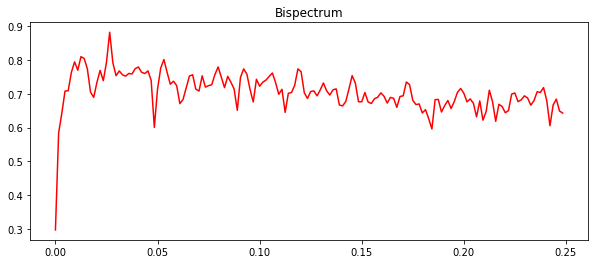

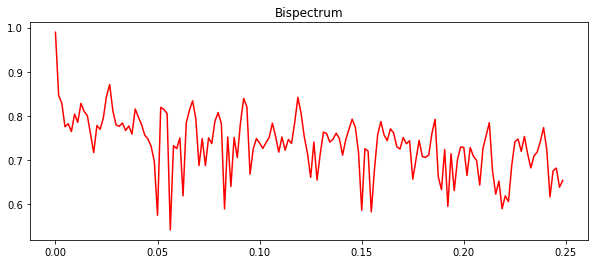

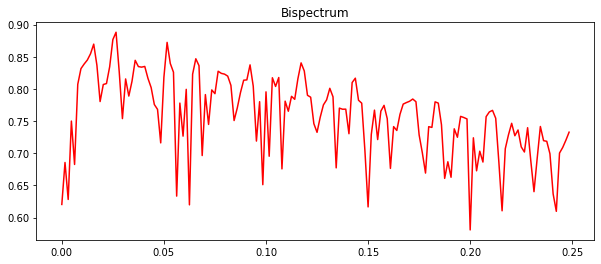

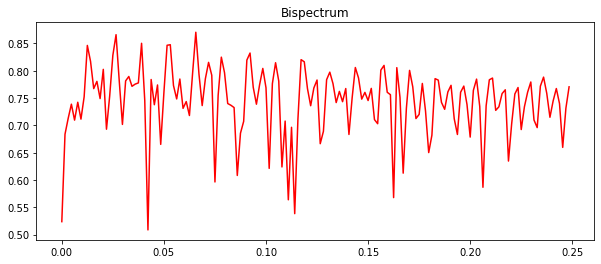

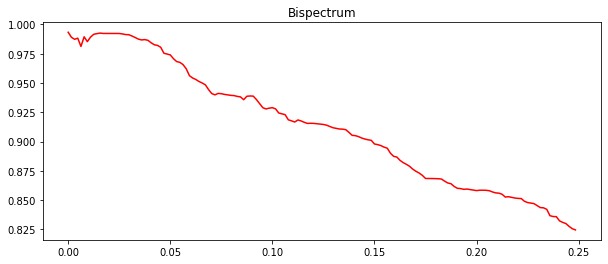

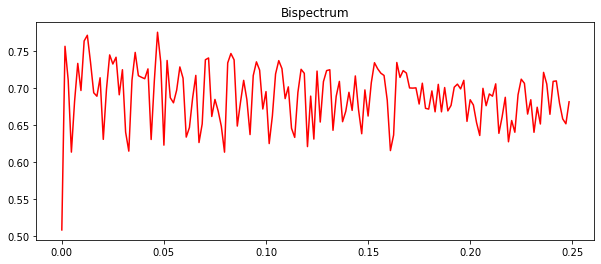

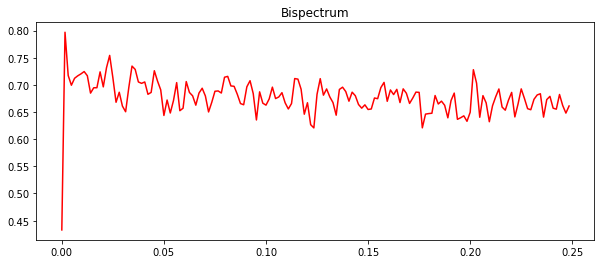

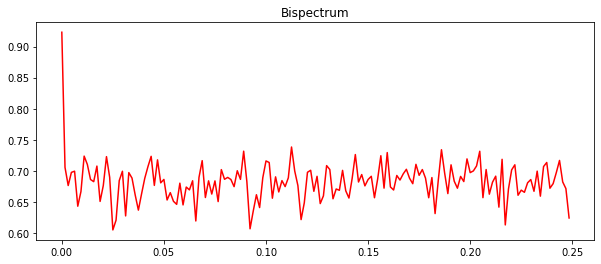

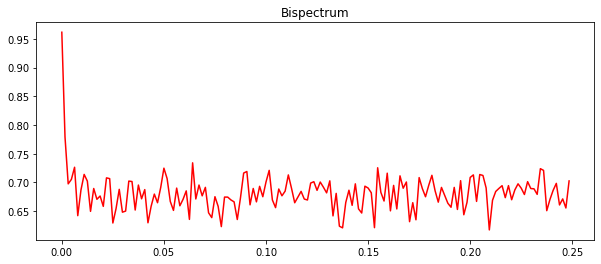

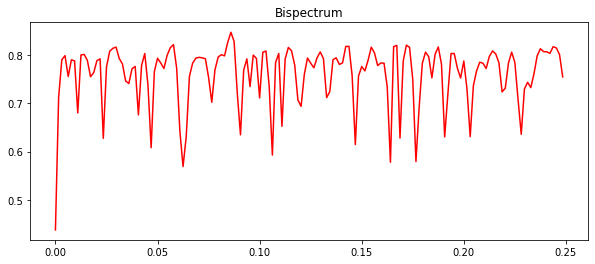

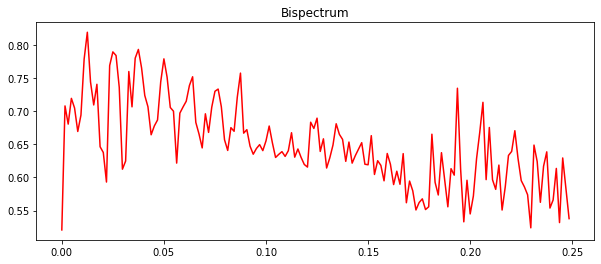

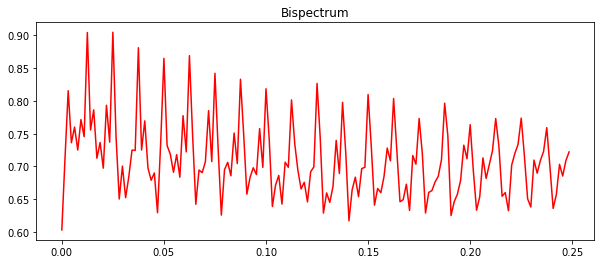

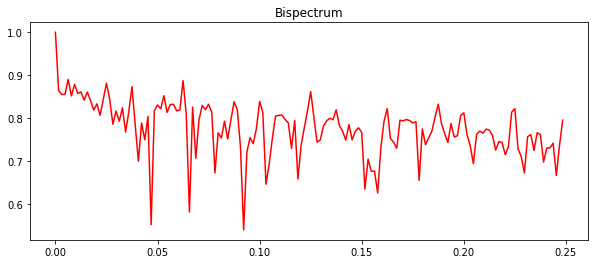

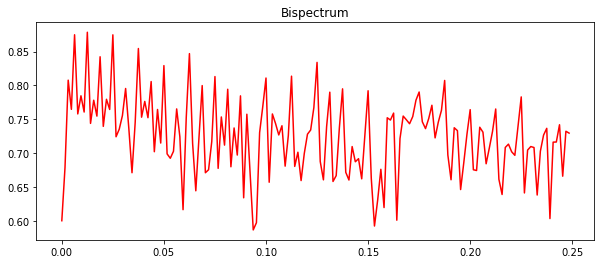

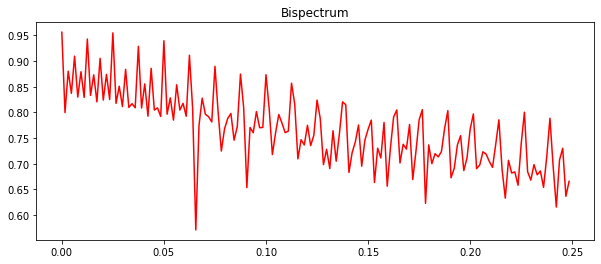

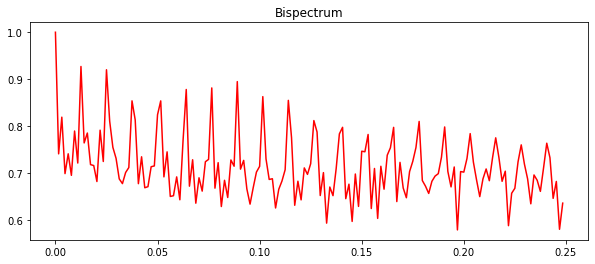

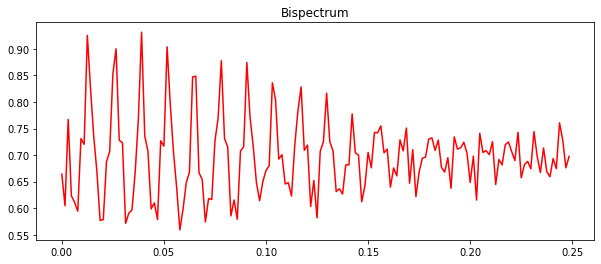

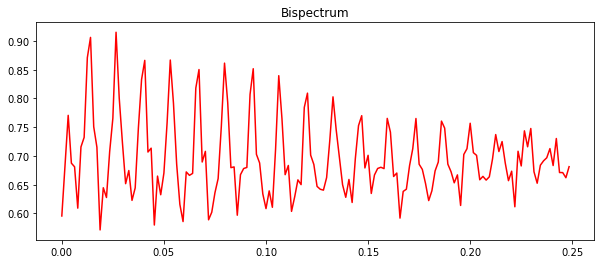

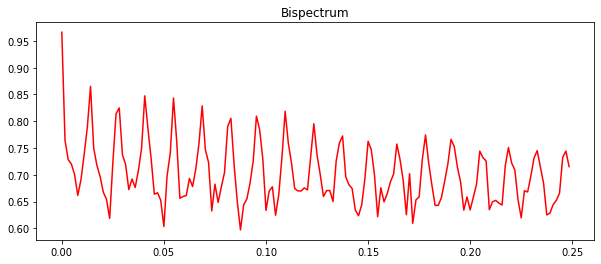

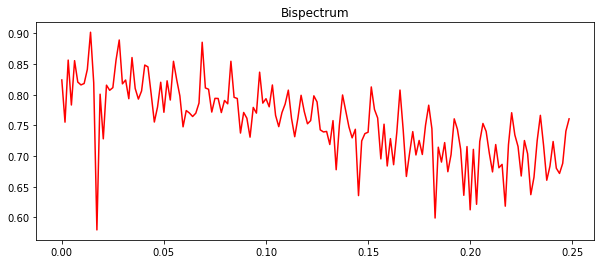

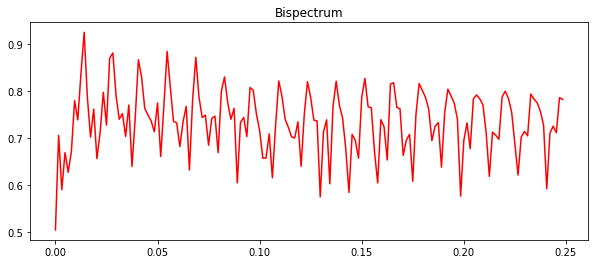

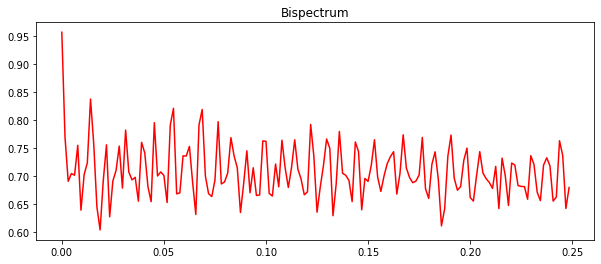

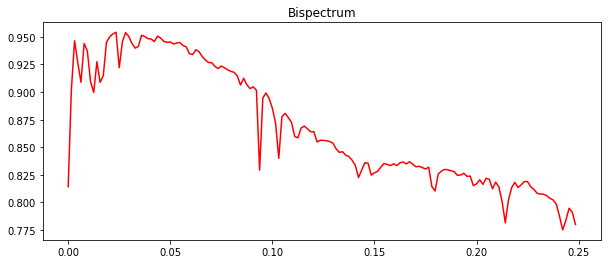

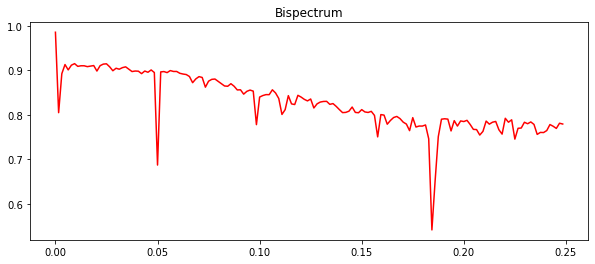

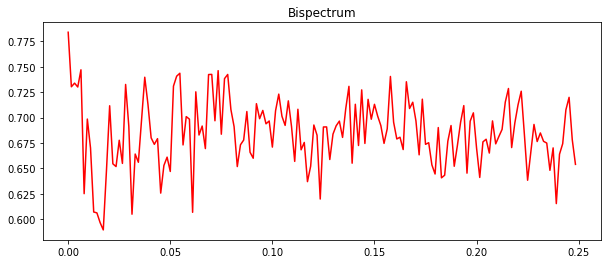

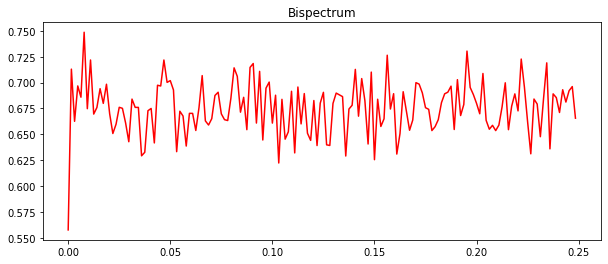

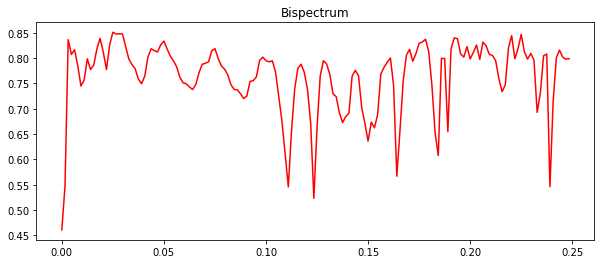

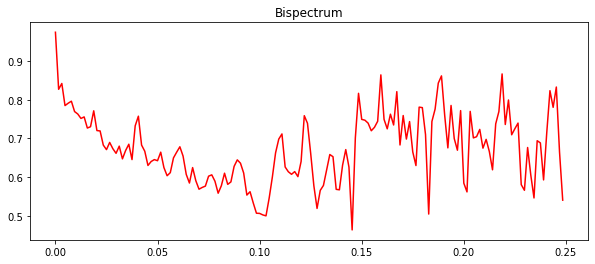

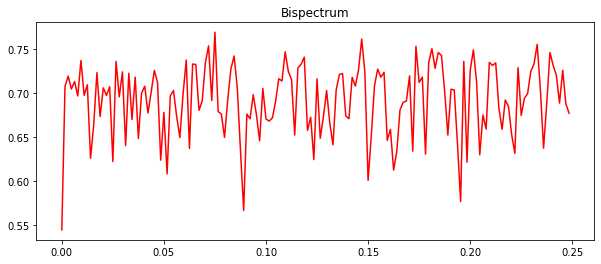

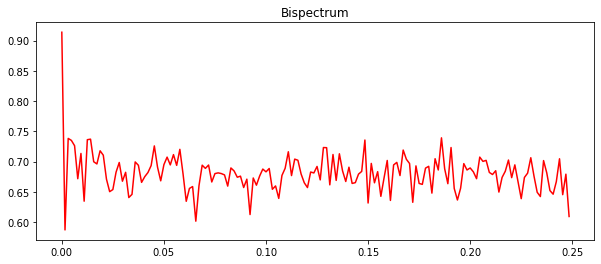

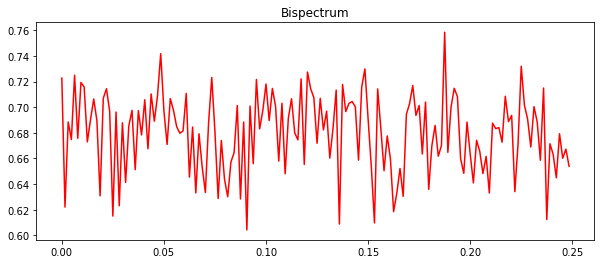

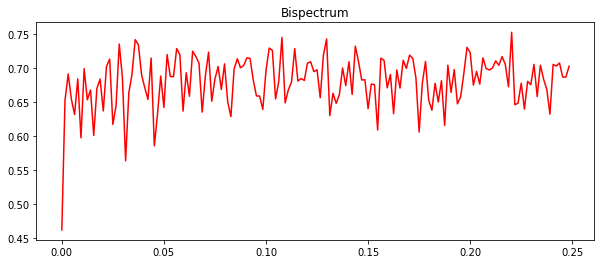

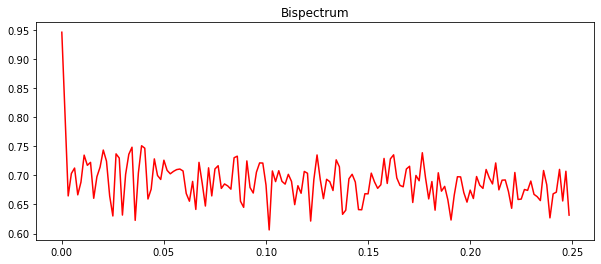

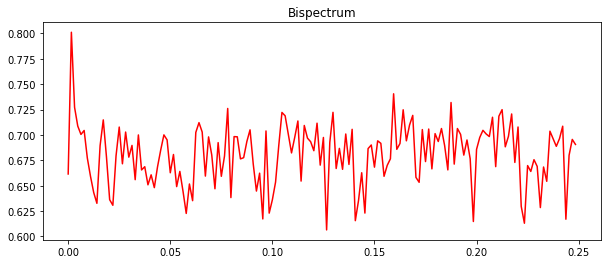

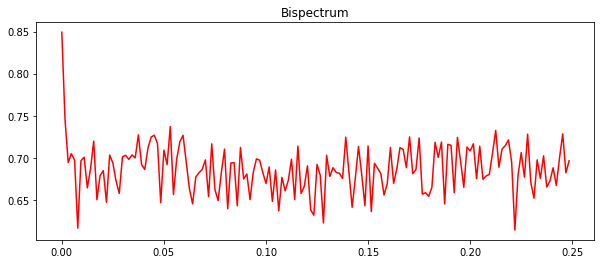

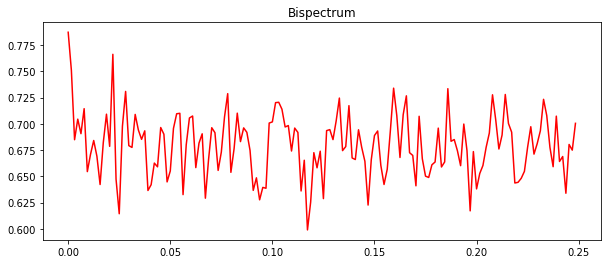

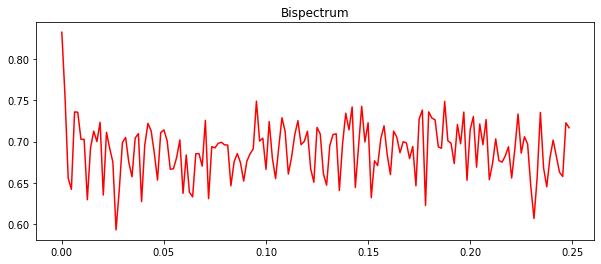

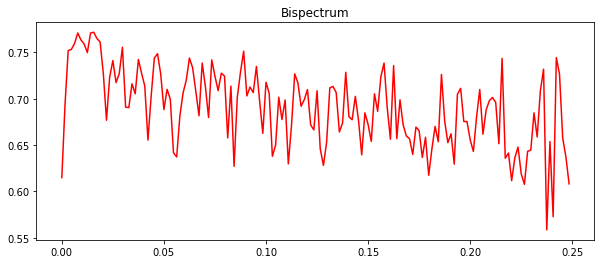

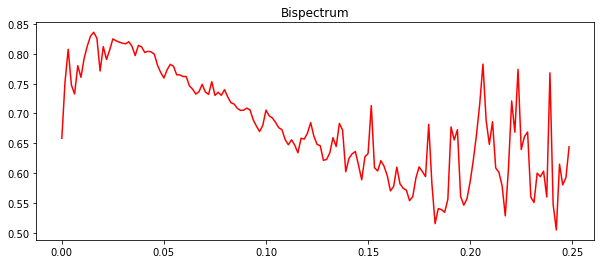

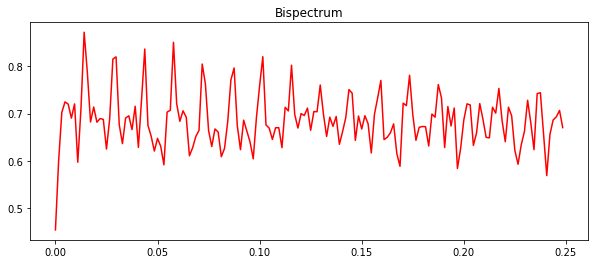

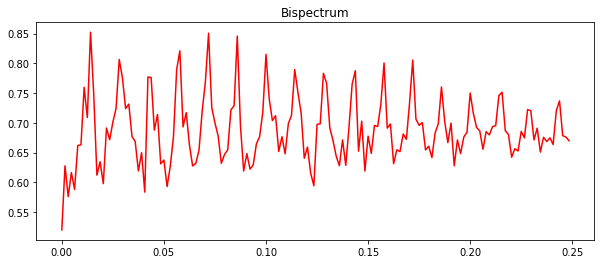

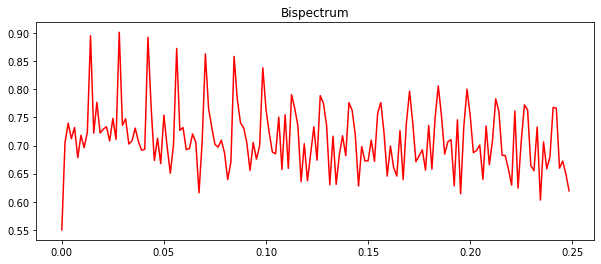

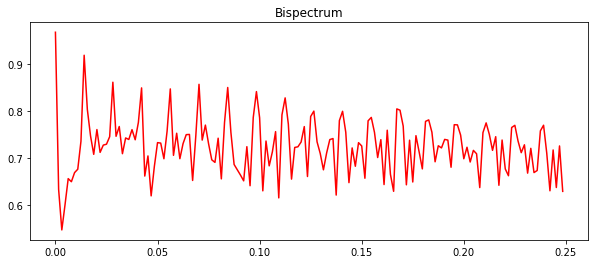

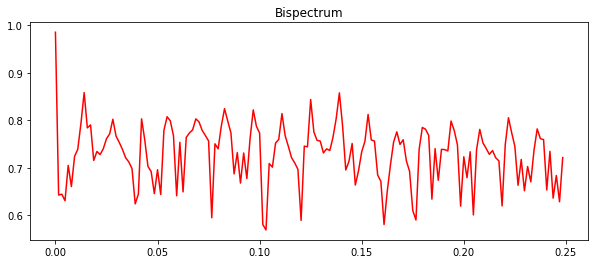

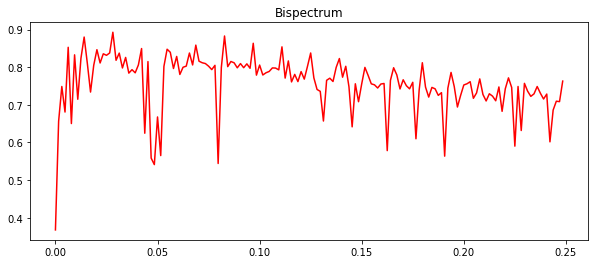

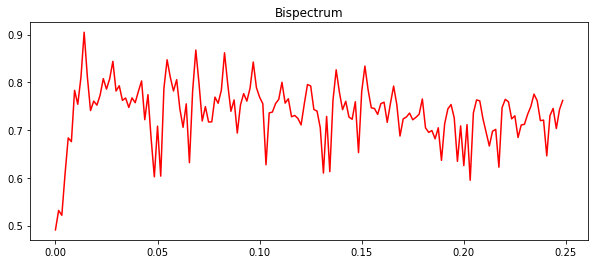

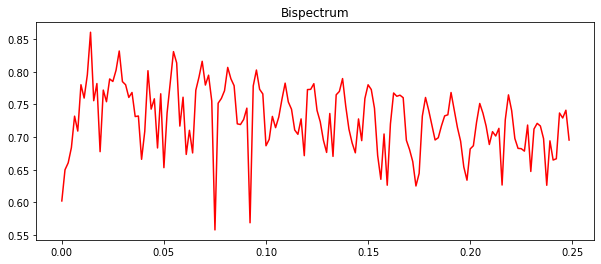

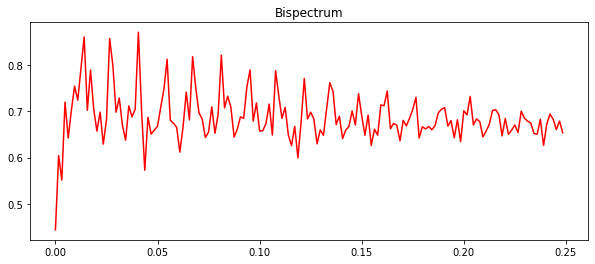

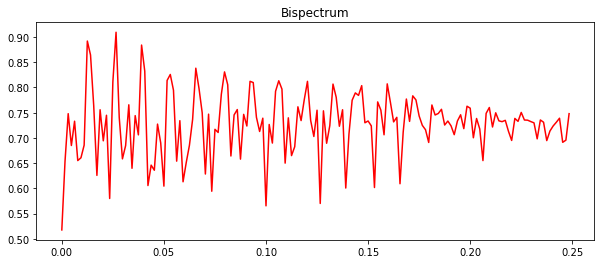

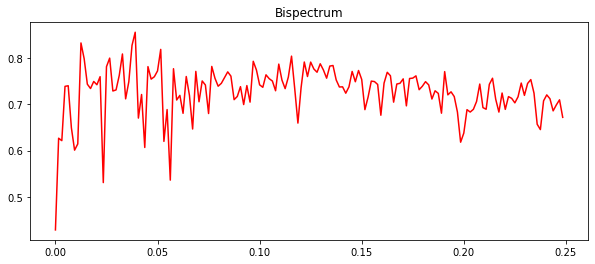

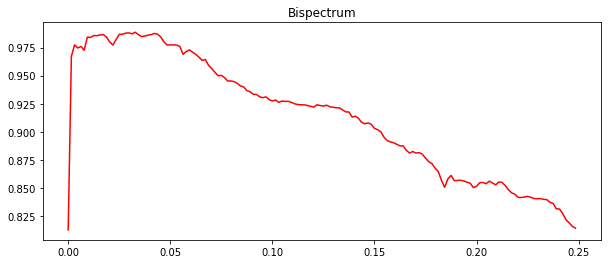

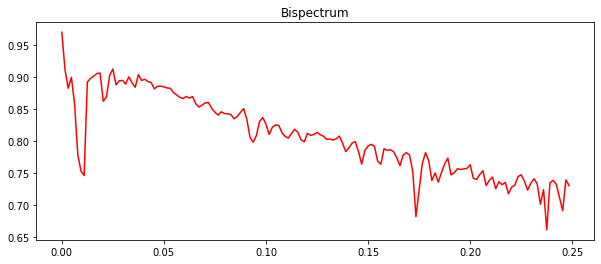

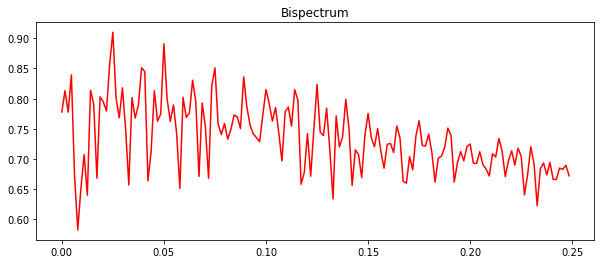

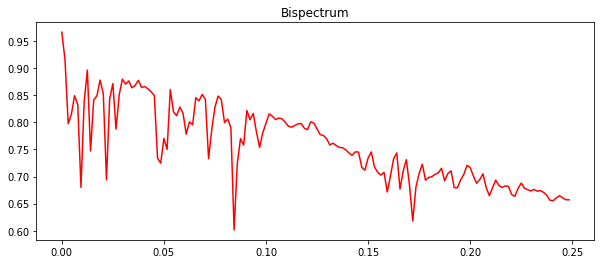

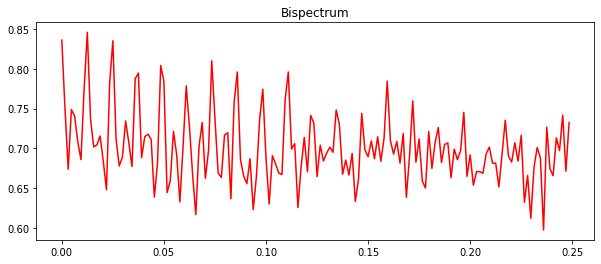

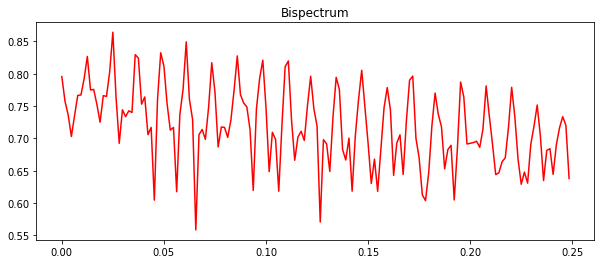

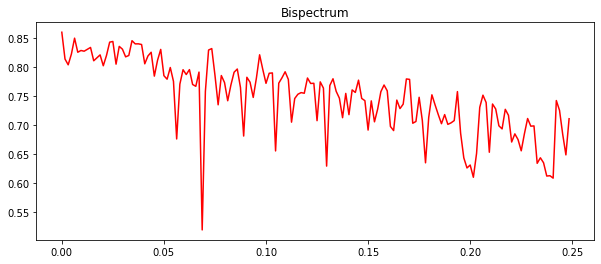

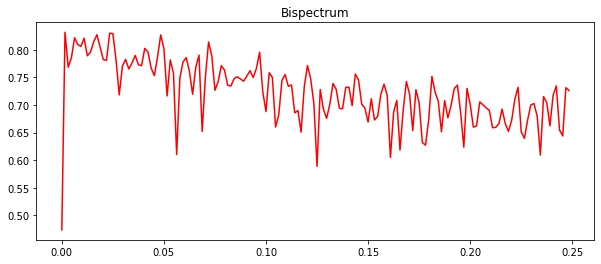

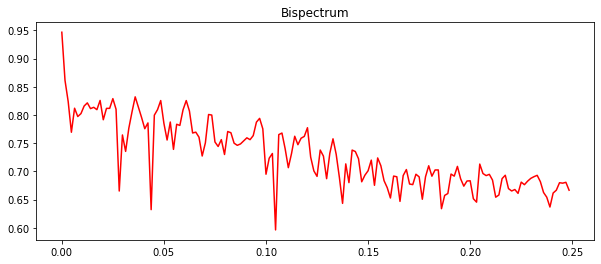

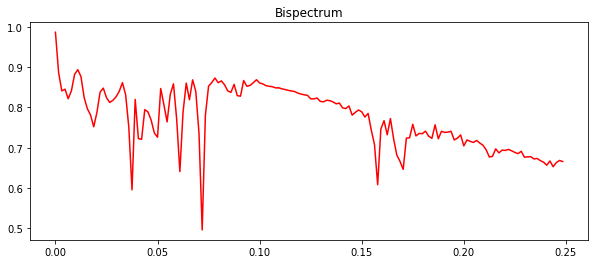

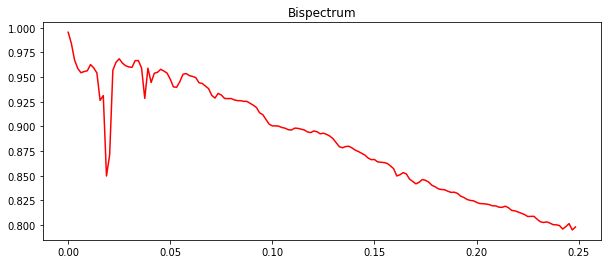

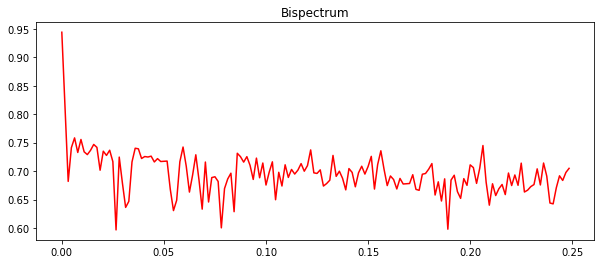

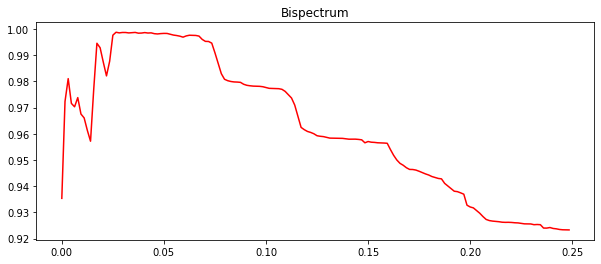

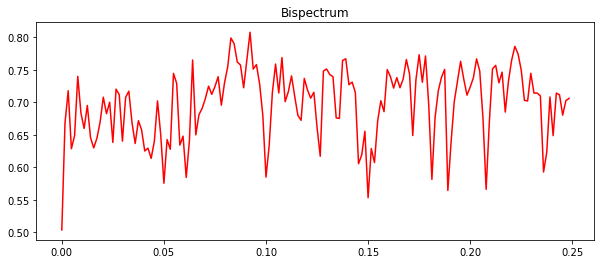

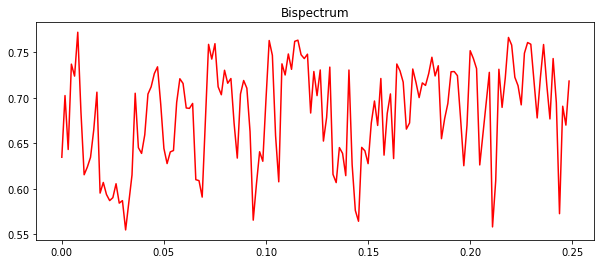

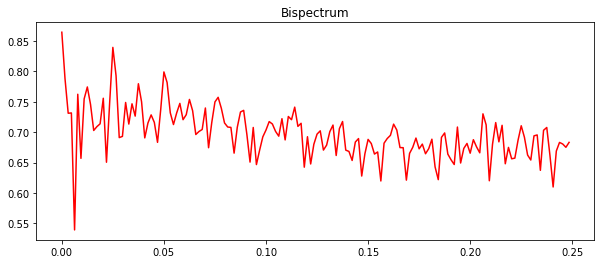

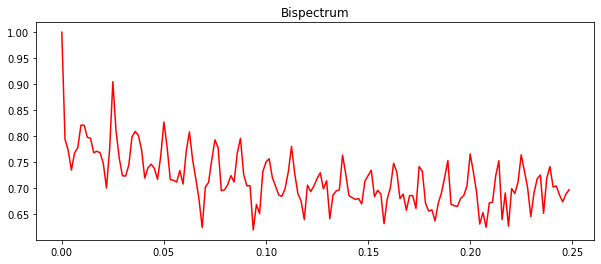

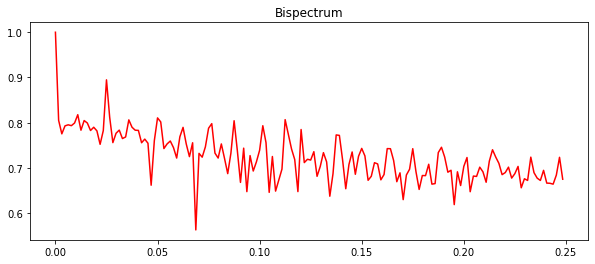

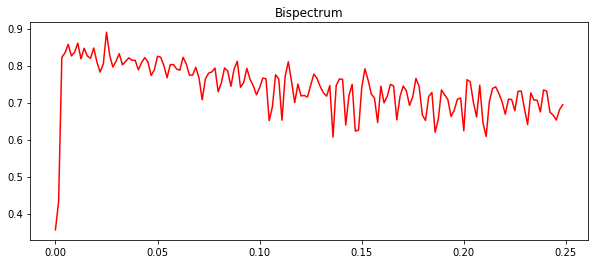

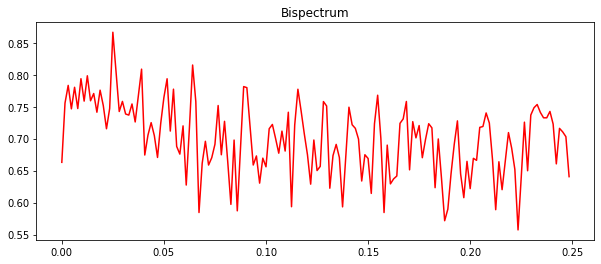

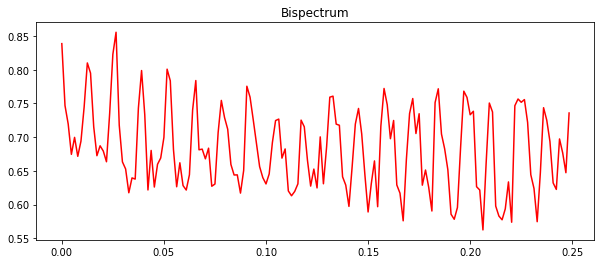

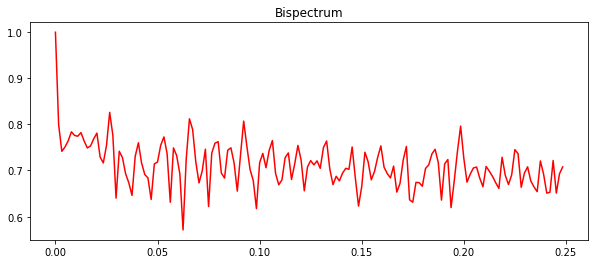

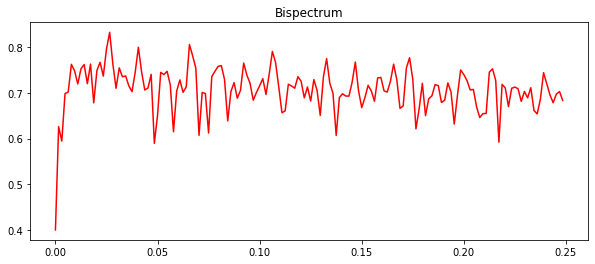

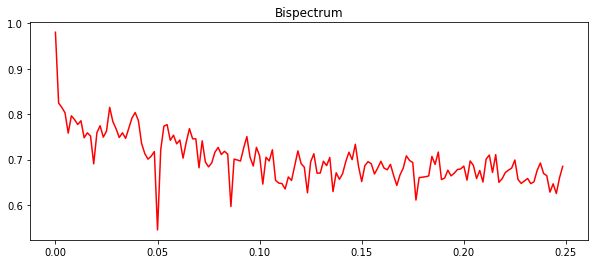

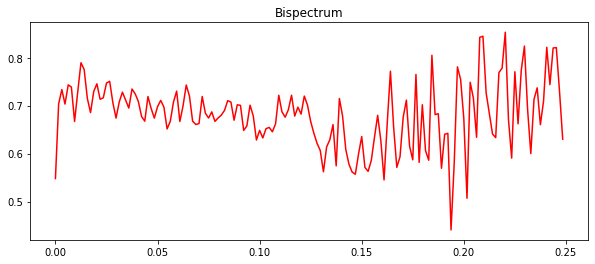

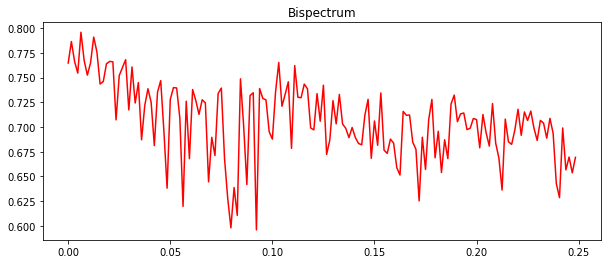

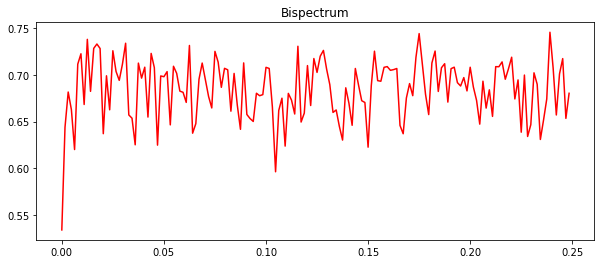

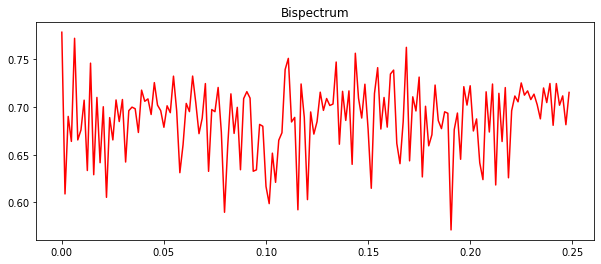

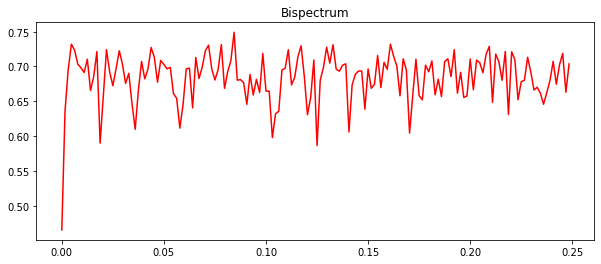

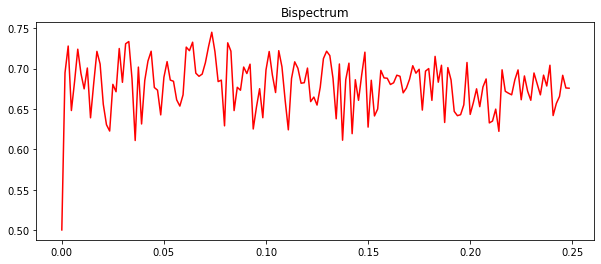

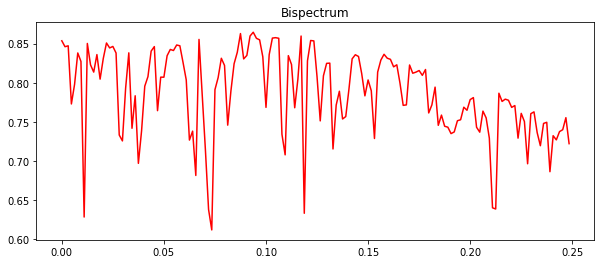

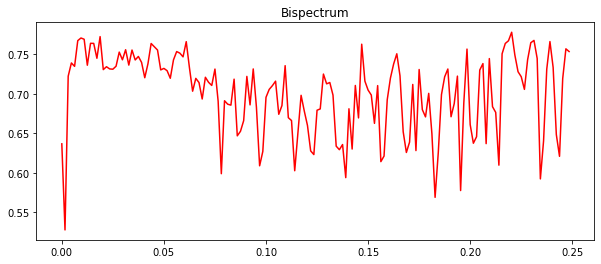

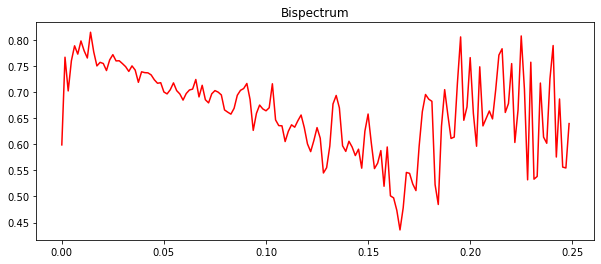

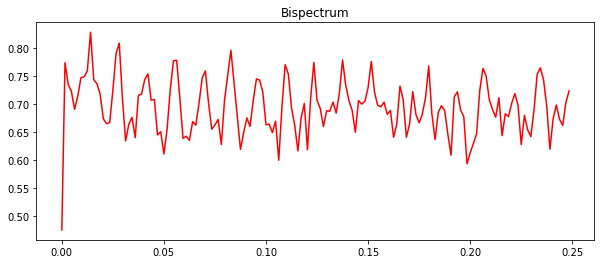

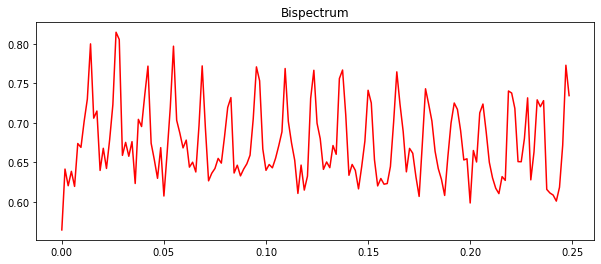

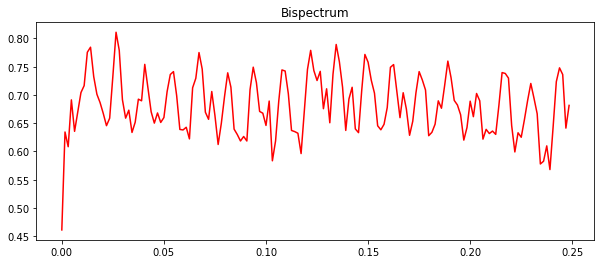

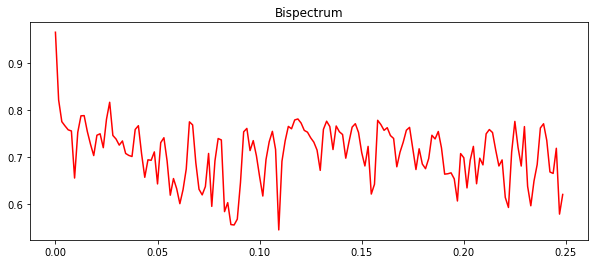

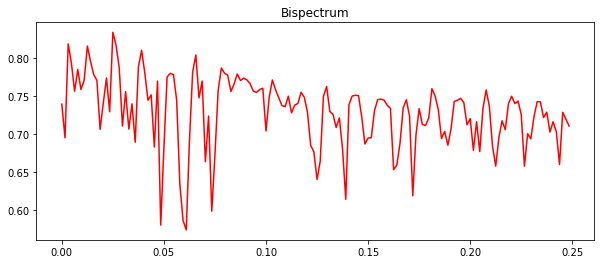

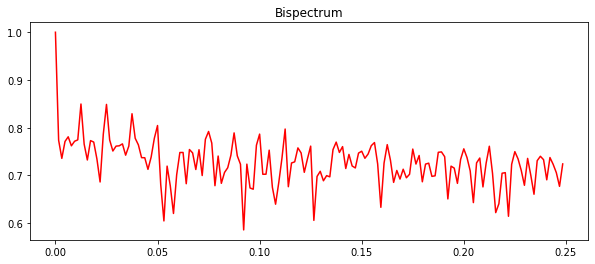

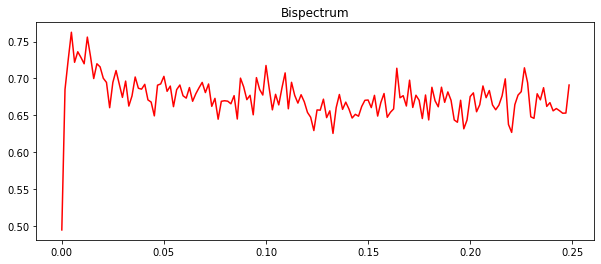

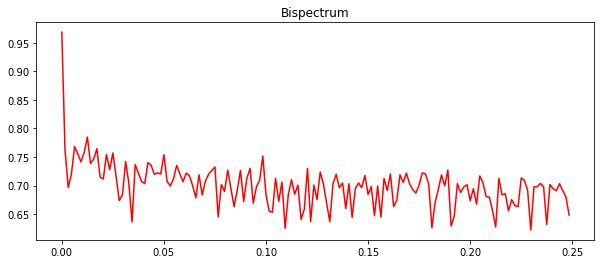

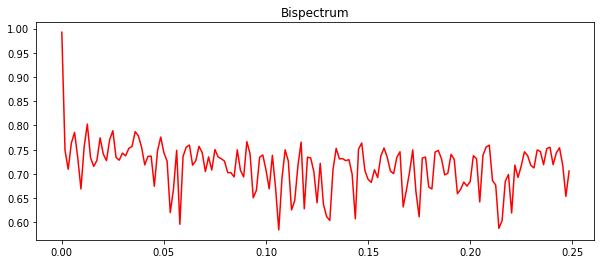

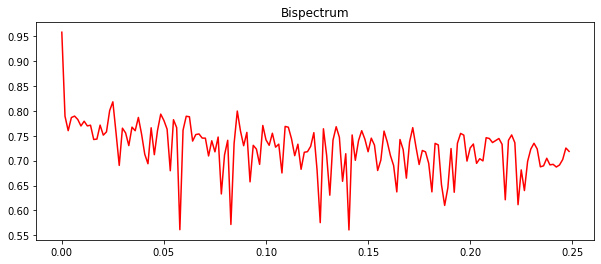

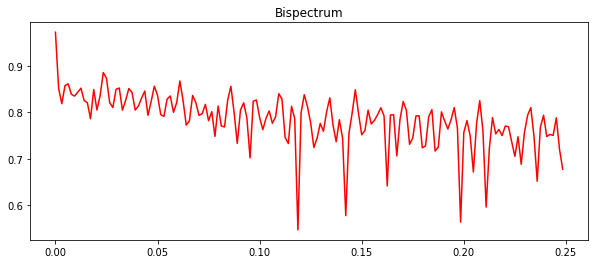

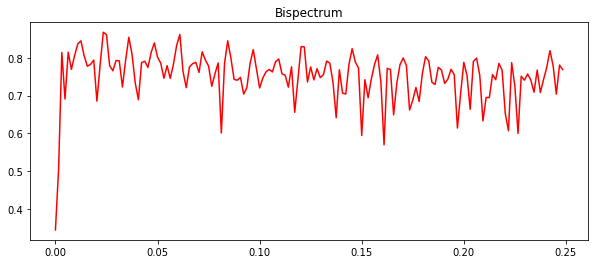

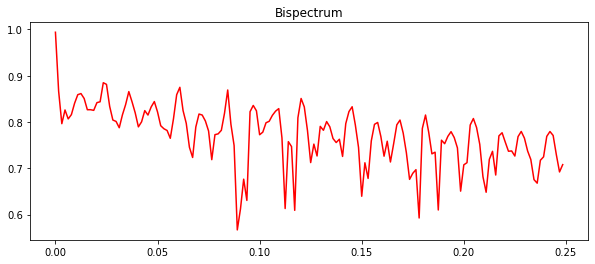

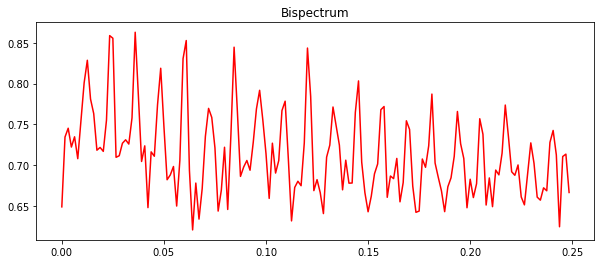

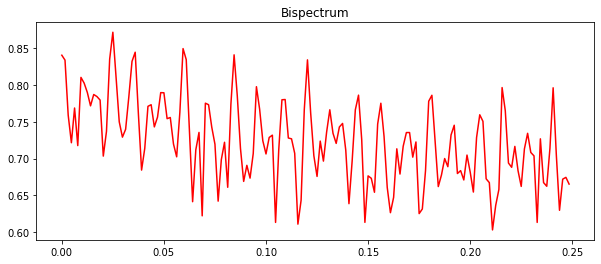

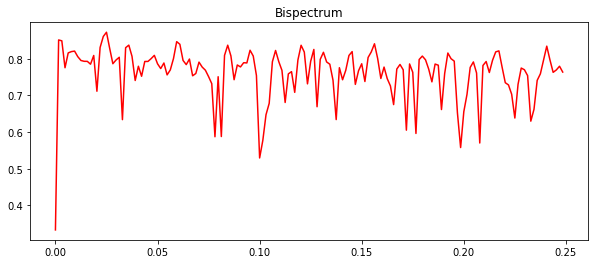

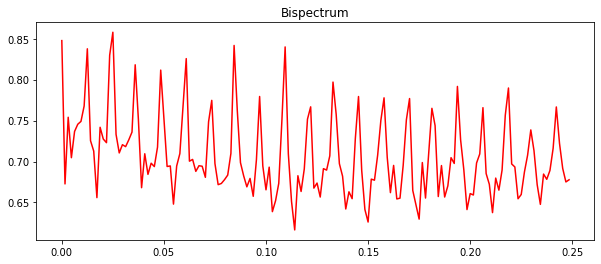

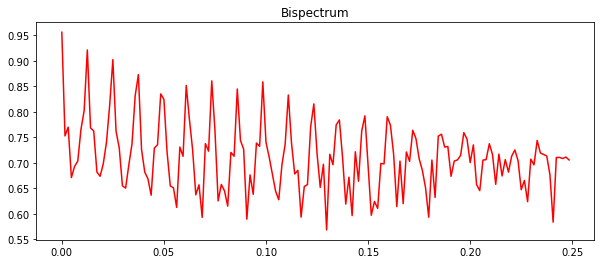

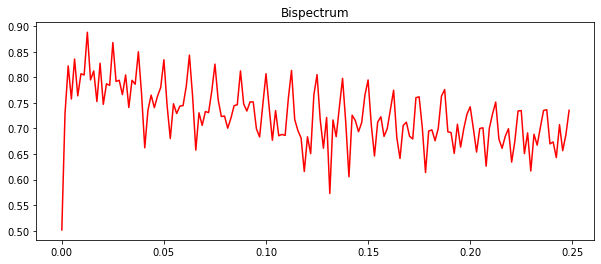

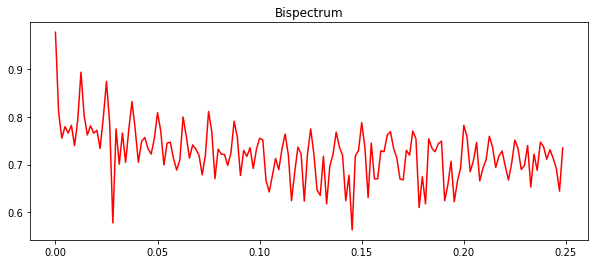

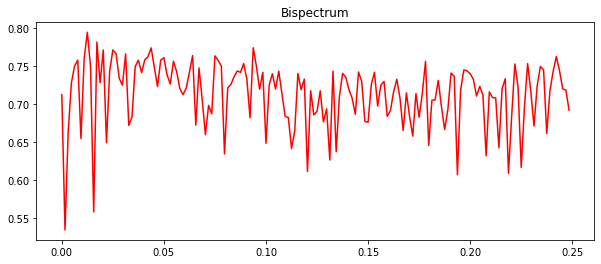

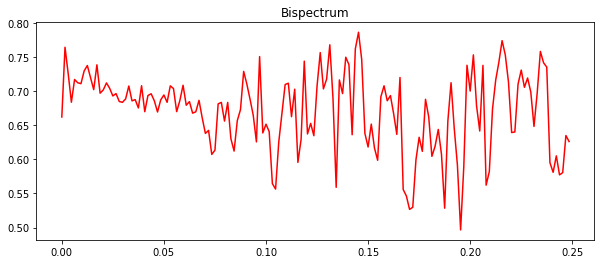

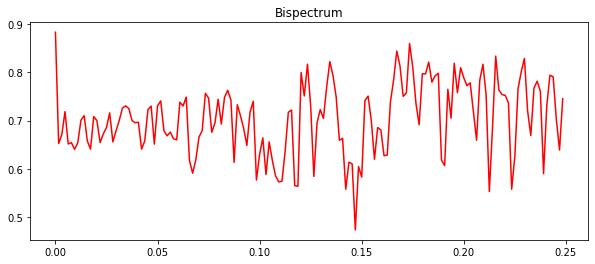

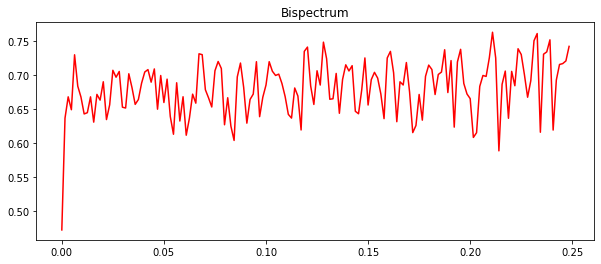

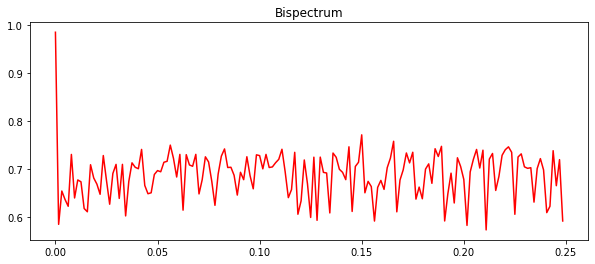

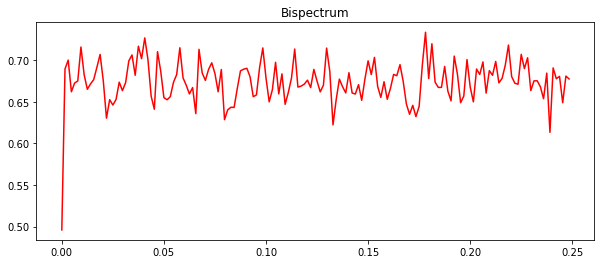

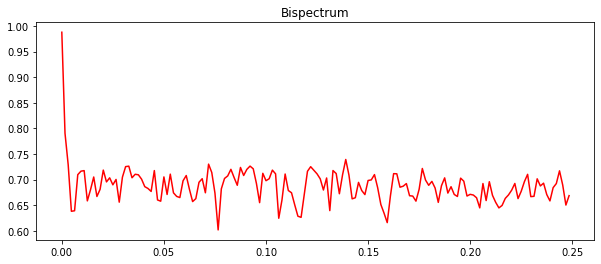

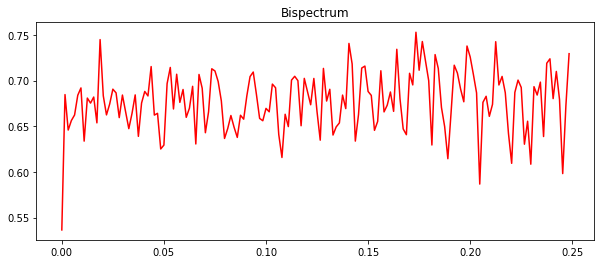

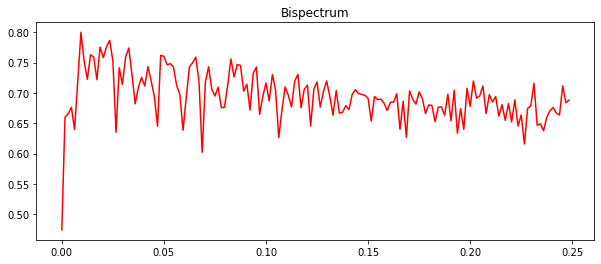

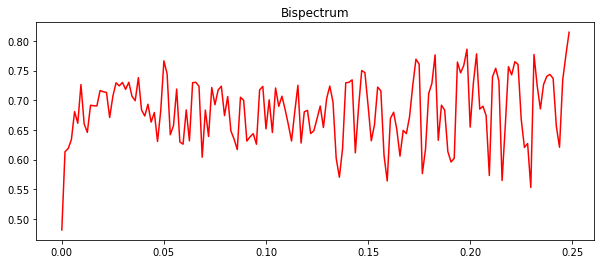

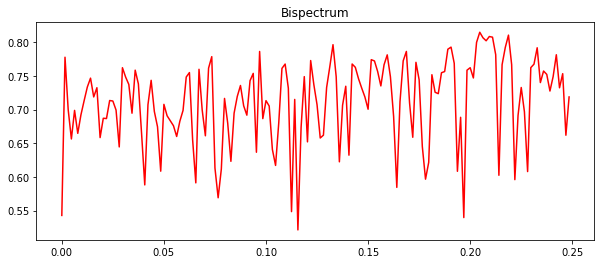

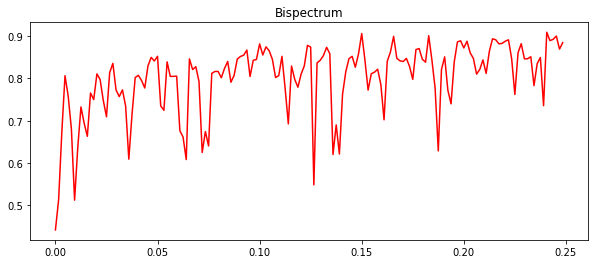

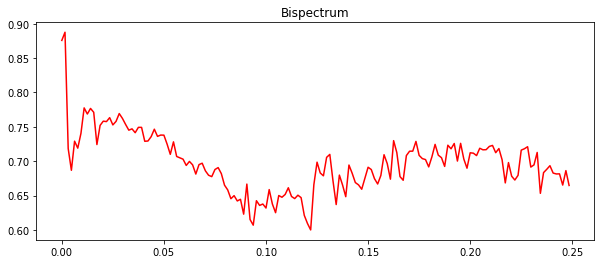

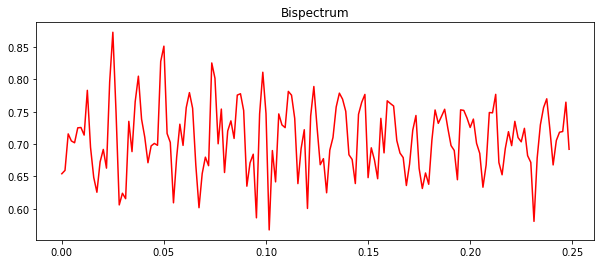

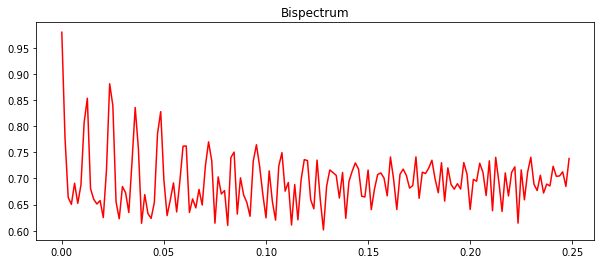

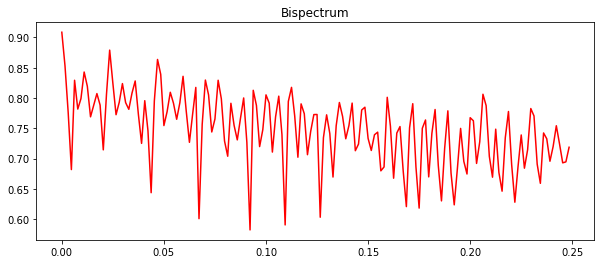

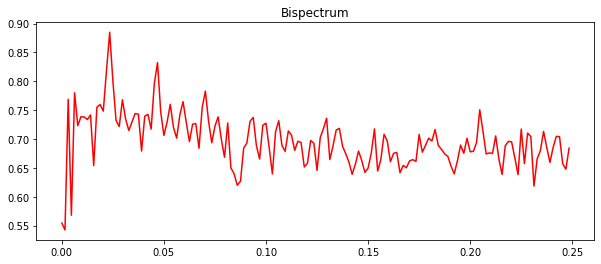

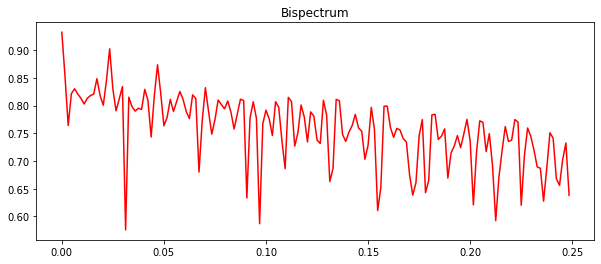

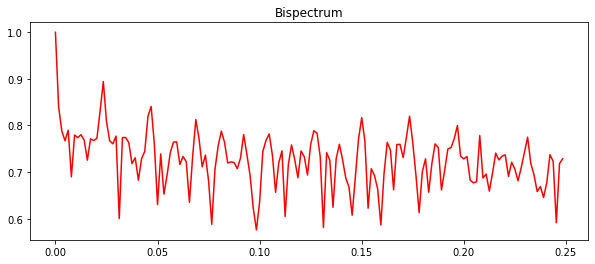

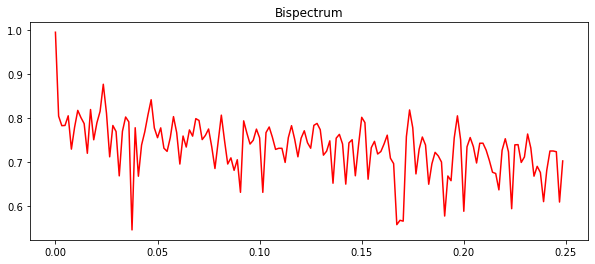

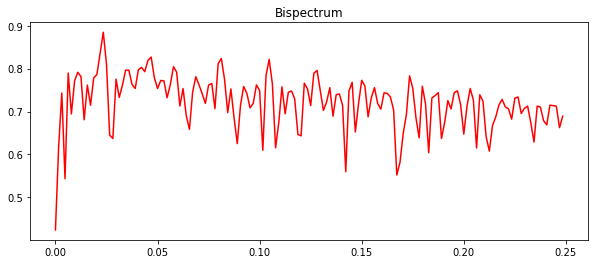

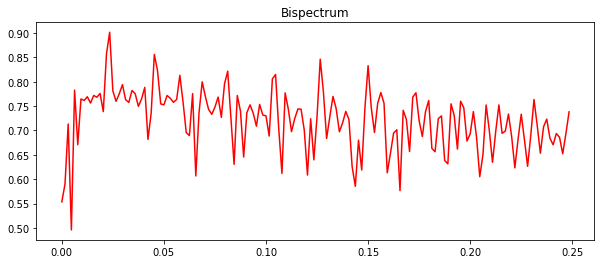

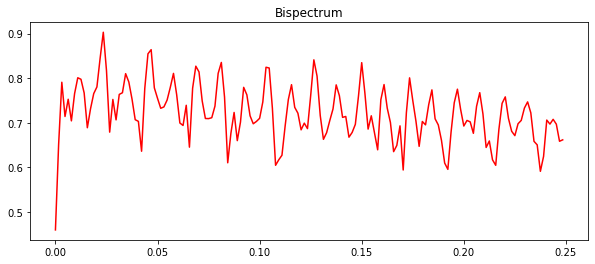

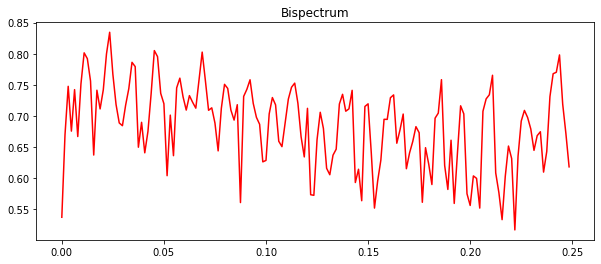

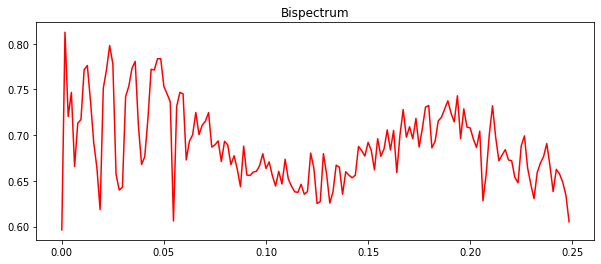

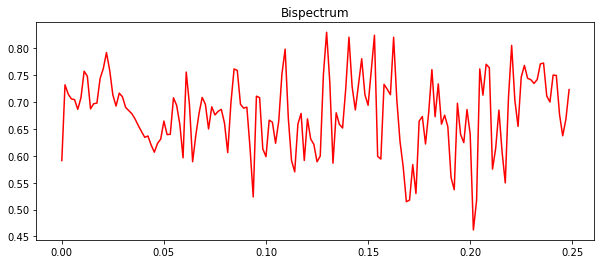

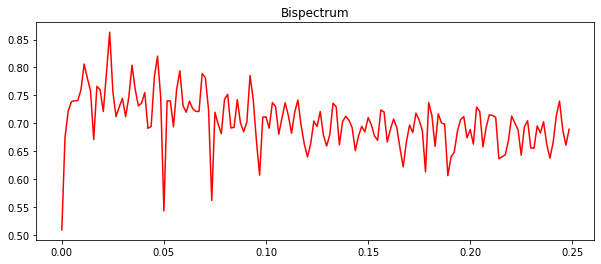

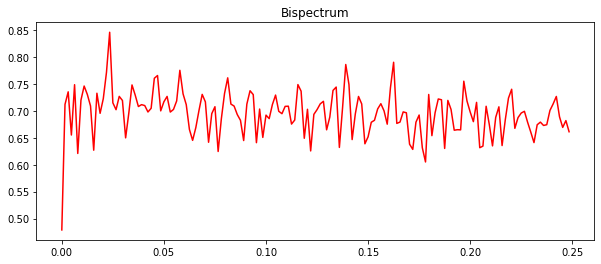

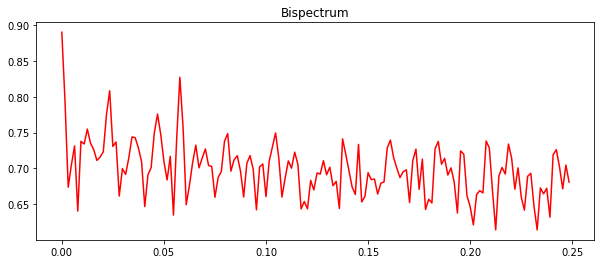

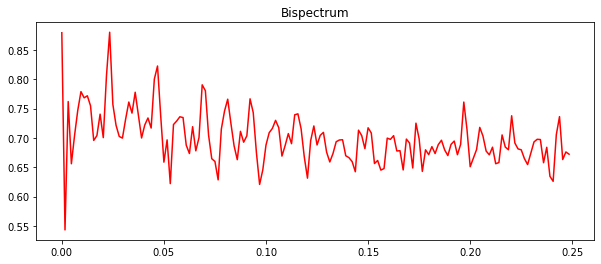

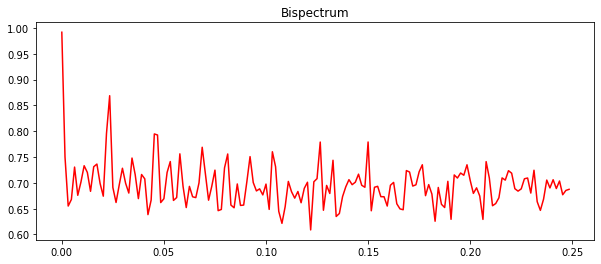

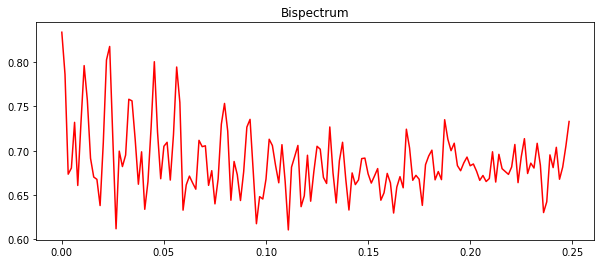

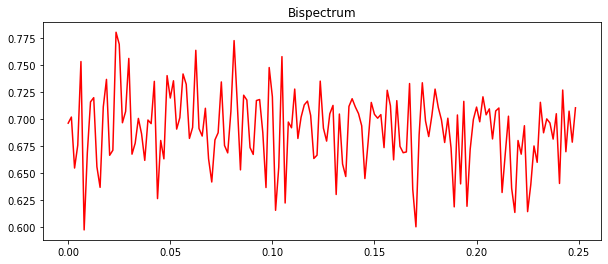

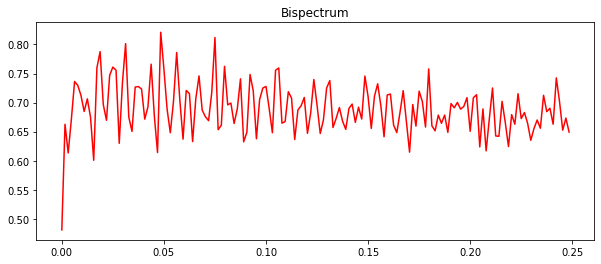

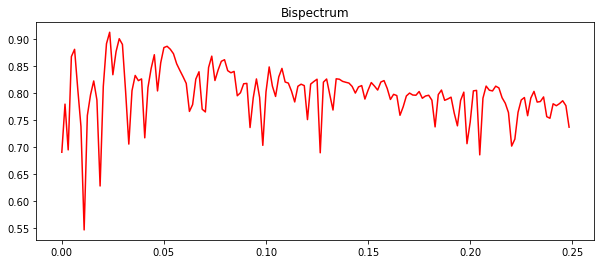

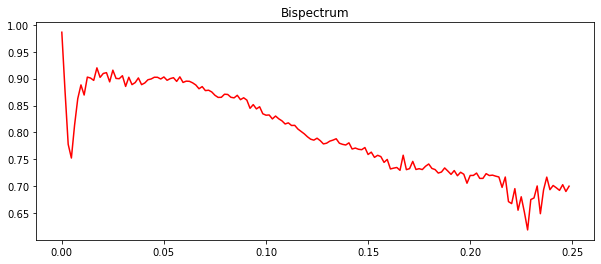

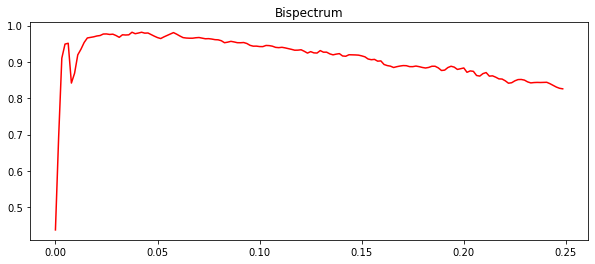

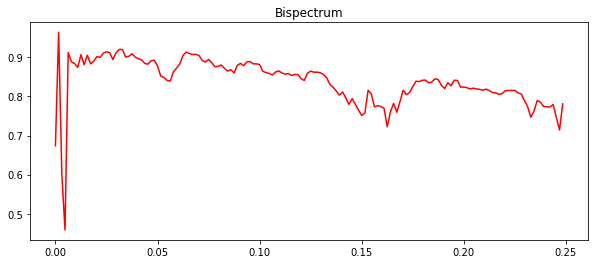

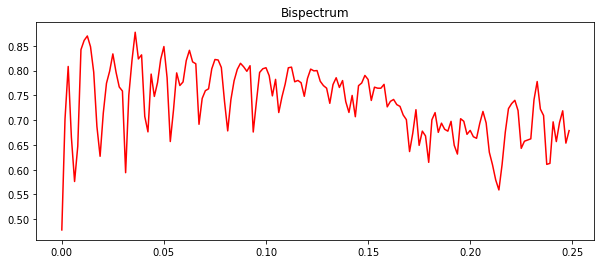

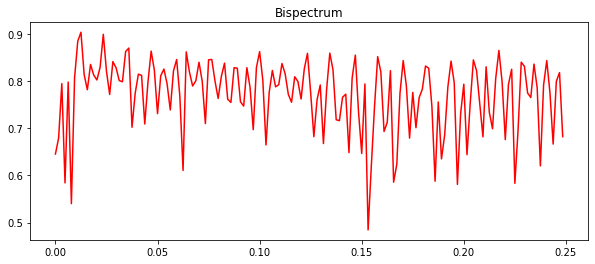

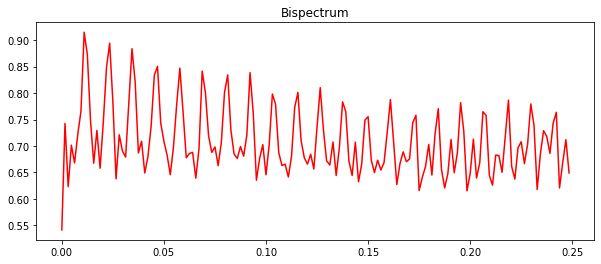

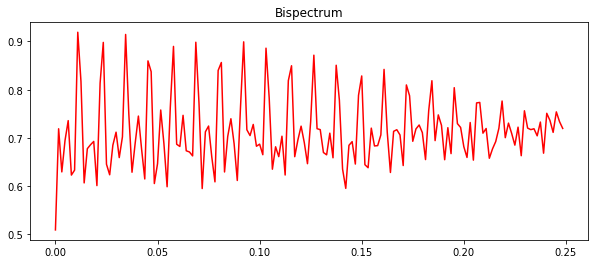

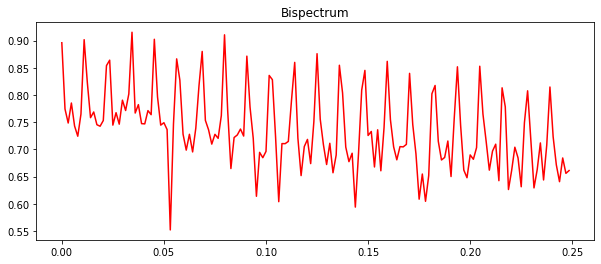

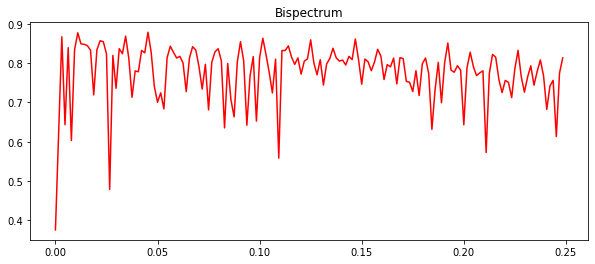

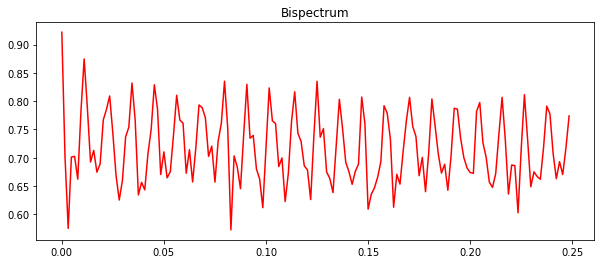

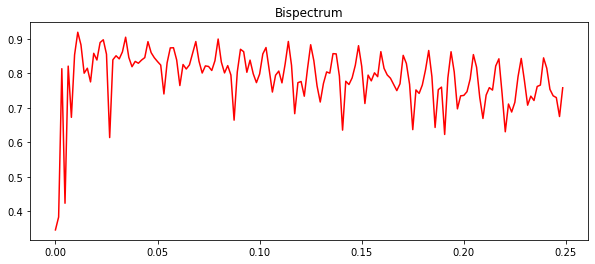

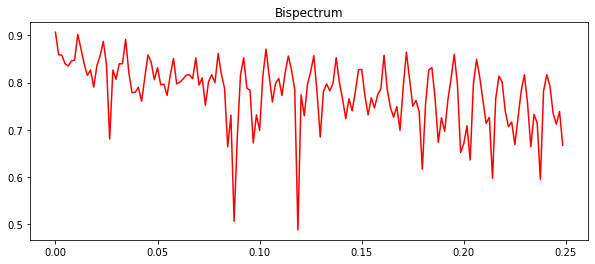

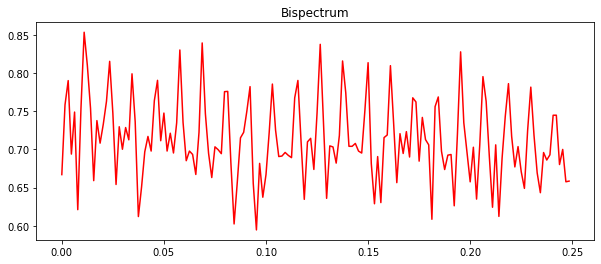

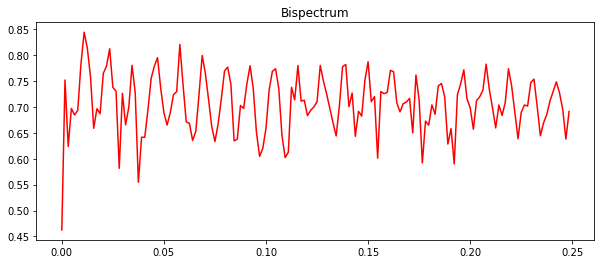

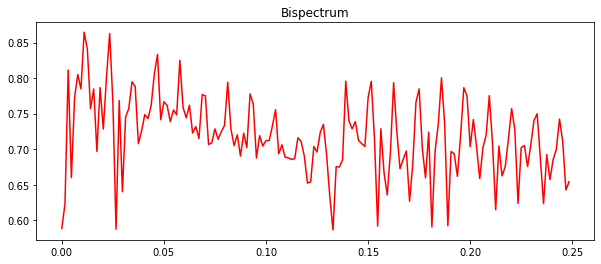

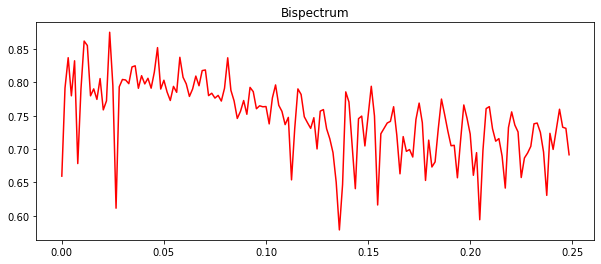

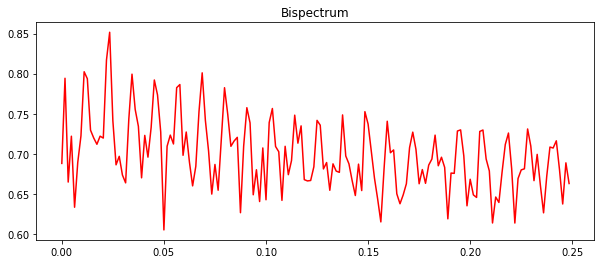

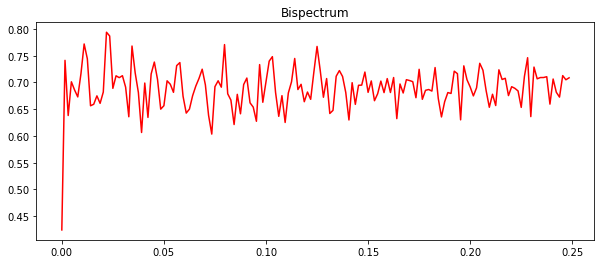

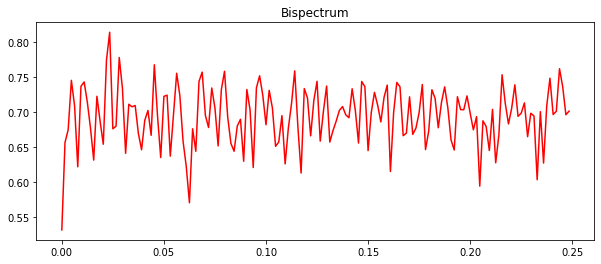

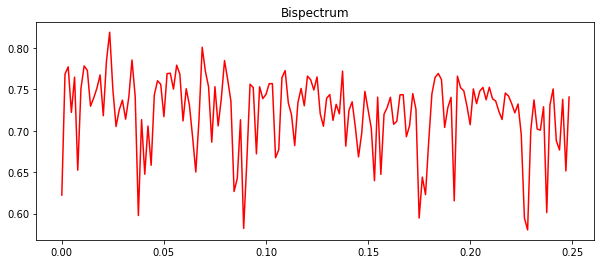

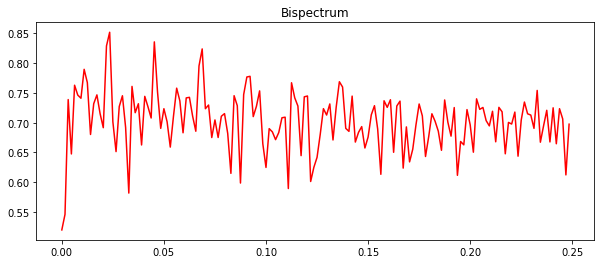

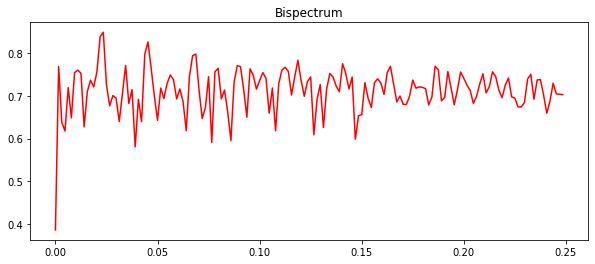

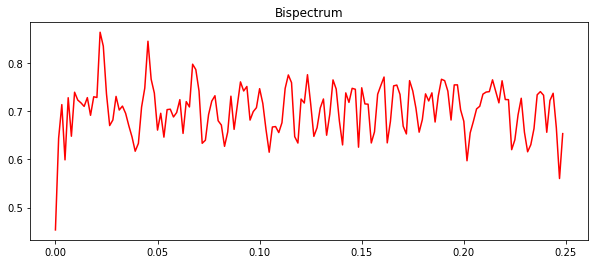

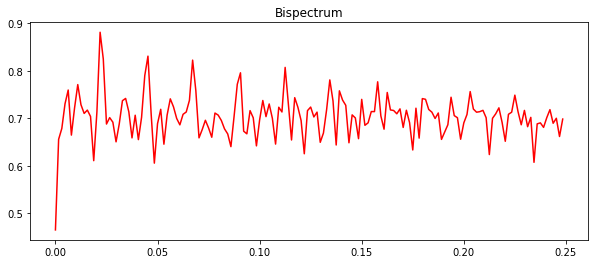

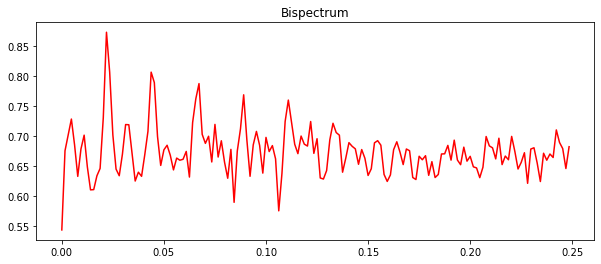

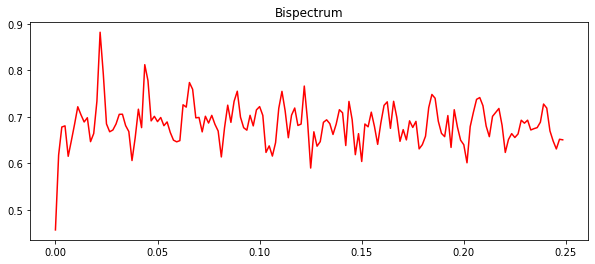

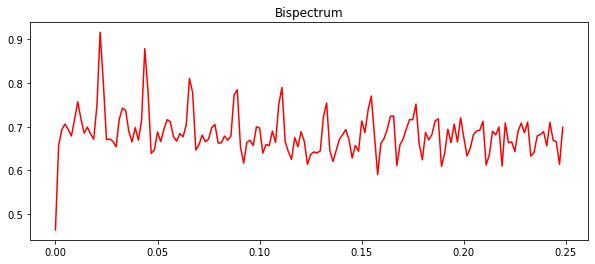

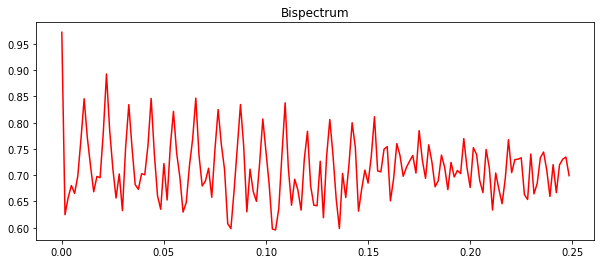

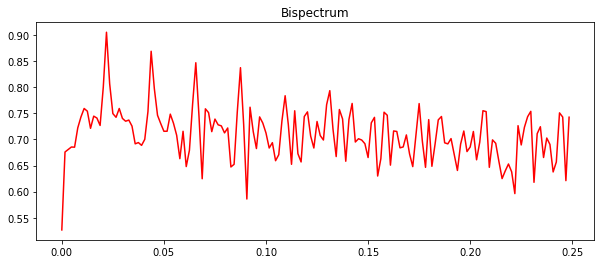

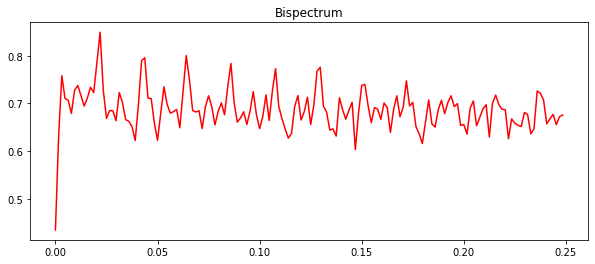

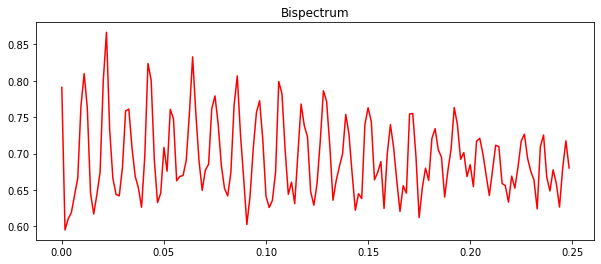

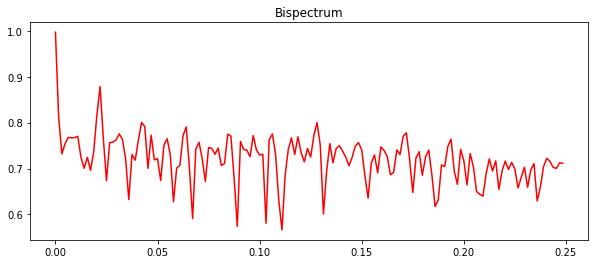

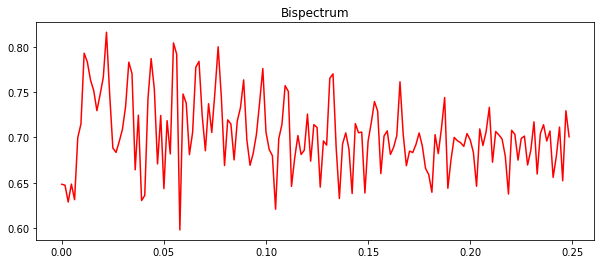

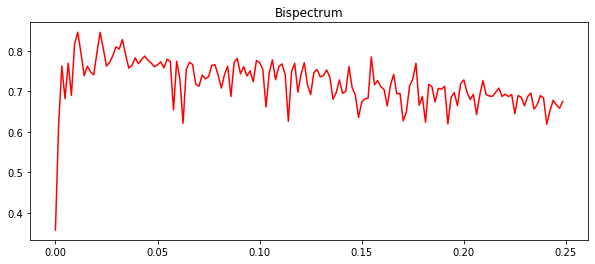

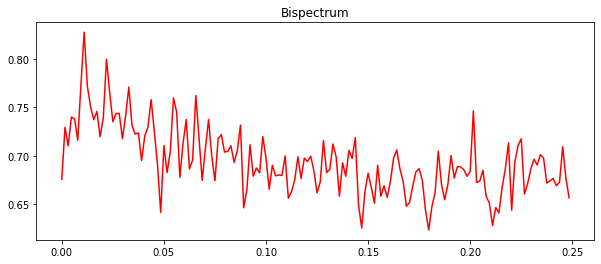

In [952]:
start = 2230
end = 51160
while start < end:
    f_start = start
    f_end = start + 480
    freq1, freq2, bicoh = polycoherence(y[f_start:f_end], sr, **kw)
    #plot_polycoherence(freq1, freq2, bicoh)
    freq1 = normalize_freq(freq1, sr)
    column_sums = bicoh.sum(axis=0)
    bicoh_norm = [float(i)/len(column_sums) for i in column_sums]
    plt.figure(figsize=(10, 4))
    plt.plot(freq1, bicoh_norm, color="r")
    plt.title("Bispectrum")
    name = str(f_start)+'-'+str(f_end)+'.jpg'
    plt.savefig(name)
    start += 240

## Spectrogram

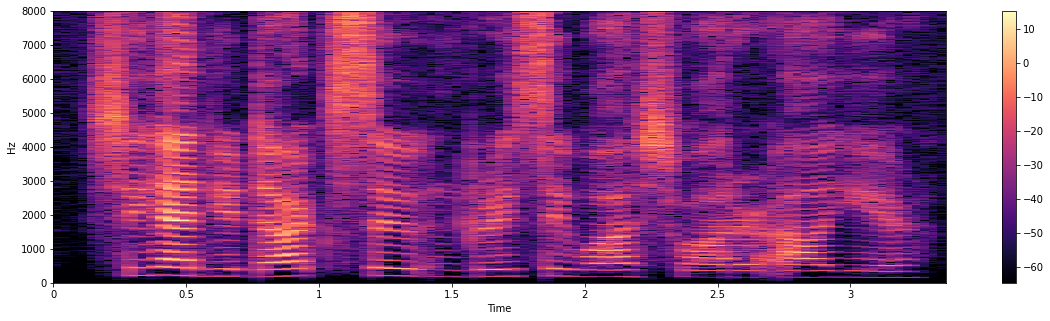

In [52]:
X = librosa.stft(x)
#converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()